In [1]:
%load_ext autoreload
%autoreload 2

%env CUBLAS_WORKSPACE_CONFIG=":4096:8" # per impostare algoritmi deterministici

import itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from multiprocessing import Pool
import time
from tqdm import tqdm

from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits, get_weights_from_init_method
from train import Trainer, Dataset
from embedding import Embedding
import experiments
from experiments import Experiments, experiment_node_embedding, all_seeds
from plot_model import plot_model
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial,plot_onlyloss_ripetizioni_stesso_trial_superimposed)
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect
from config_valid import Config, TrainingMode
from GridConfigurations import GridConfigurations, open_df_results

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

import pickle 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()
#pd.set_option('display.height', 500)

env: CUBLAS_WORKSPACE_CONFIG=":4096:8" # per impostare algoritmi deterministici


In [2]:
rootsave = Path("output_plots/")
config_file = "configurations/classification_cm-diversi_init_weights.yml"

# Studio al variare dei pesi di init

## Show tutte le diverse distribuzioni di pesi iniziali di Pytorch

In [8]:
metodi = ['normal', 'uniform', 'eye', 'xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal', 'trunc_normal', 'orthogonal', 'sparse']

In [4]:
config_class = Config(config_file)
trainer = Trainer(config_class)
diz_trials = {'model.init_weights': metodi}
gc = GridConfigurations(config_class, diz_trials)
gc.make_configs()

0 configurazioni saltate su 10


In [32]:
methods_weights = []
for i, c in enumerate(gc.configs):
    custom_weight = torch.empty((10000,1000))
    weights = get_weights_from_init_method(custom_weight, method=c.init_weights_mode)
    methods_weights.append(weights)

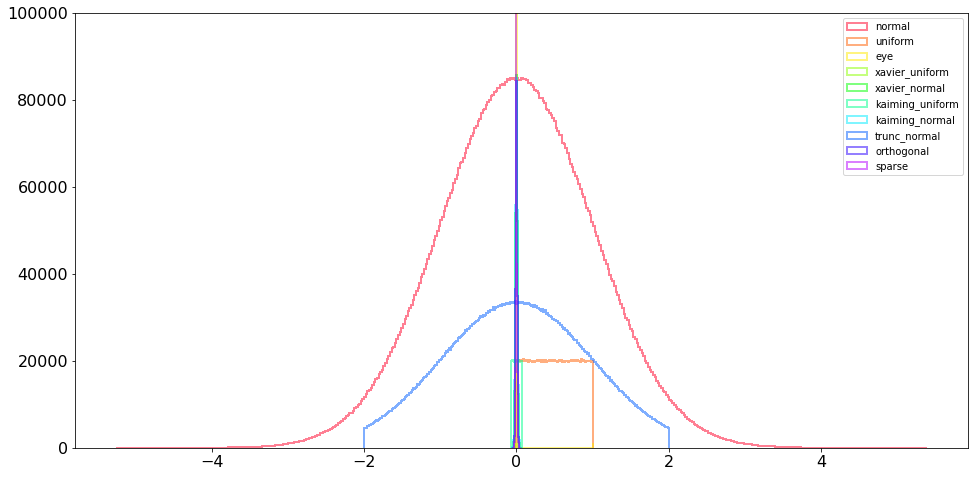

In [51]:
for i, w in enumerate(methods_weights):
    plt.hist(w.numpy().flatten(), alpha=0.5, bins=500, 
             label=f"{gc.configs[i].init_weights_mode}", histtype='step', linewidth=2, color=get_colors_to_cycle_rainbowN(10)[i]);
plt.ylim(0,100000)
plt.legend()
plt.savefig("init_weights-1.png", bbox_inches='tight')
plt.show()

In [ ]:
# plot in scala log

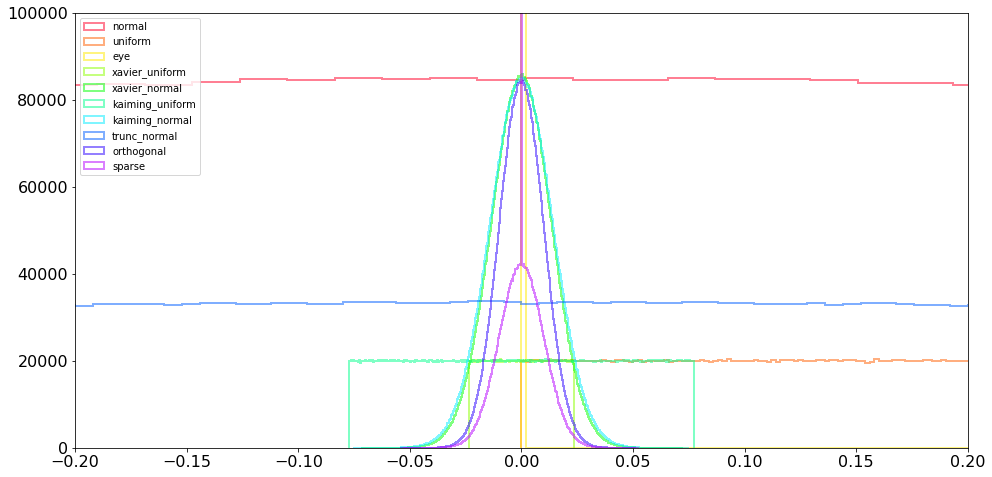

In [52]:
# lo ripeto perché deve vedersi la parte interna
for i, w in enumerate(methods_weights):
    plt.hist(w.numpy().flatten(), alpha=0.5, bins=500, label=f"{gc.configs[i].init_weights_mode}", histtype='step',
            linewidth=2, color=get_colors_to_cycle_rainbowN(10)[i]);
plt.ylim(0,100000)
plt.xlim(-.2,.2)
plt.legend()
plt.savefig("init_weights-2.png", bbox_inches='tight')
plt.show()

# Grid Search - stesso dataset

## Codice

#### Imposto un dataset all'inizio che rimanga lo stesso per tutti i tentativi

In [4]:
xp = Experiments(config_file, rootsave)

In [25]:
metodi = ['normal', 'uniform', 'eye', 'xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal', 'trunc_normal', 'orthogonal', 'sparse']

In [ ]:
xp.diversi_init_weights_stesso_dataset(metodi, ripetizioni=5)

## Risultati

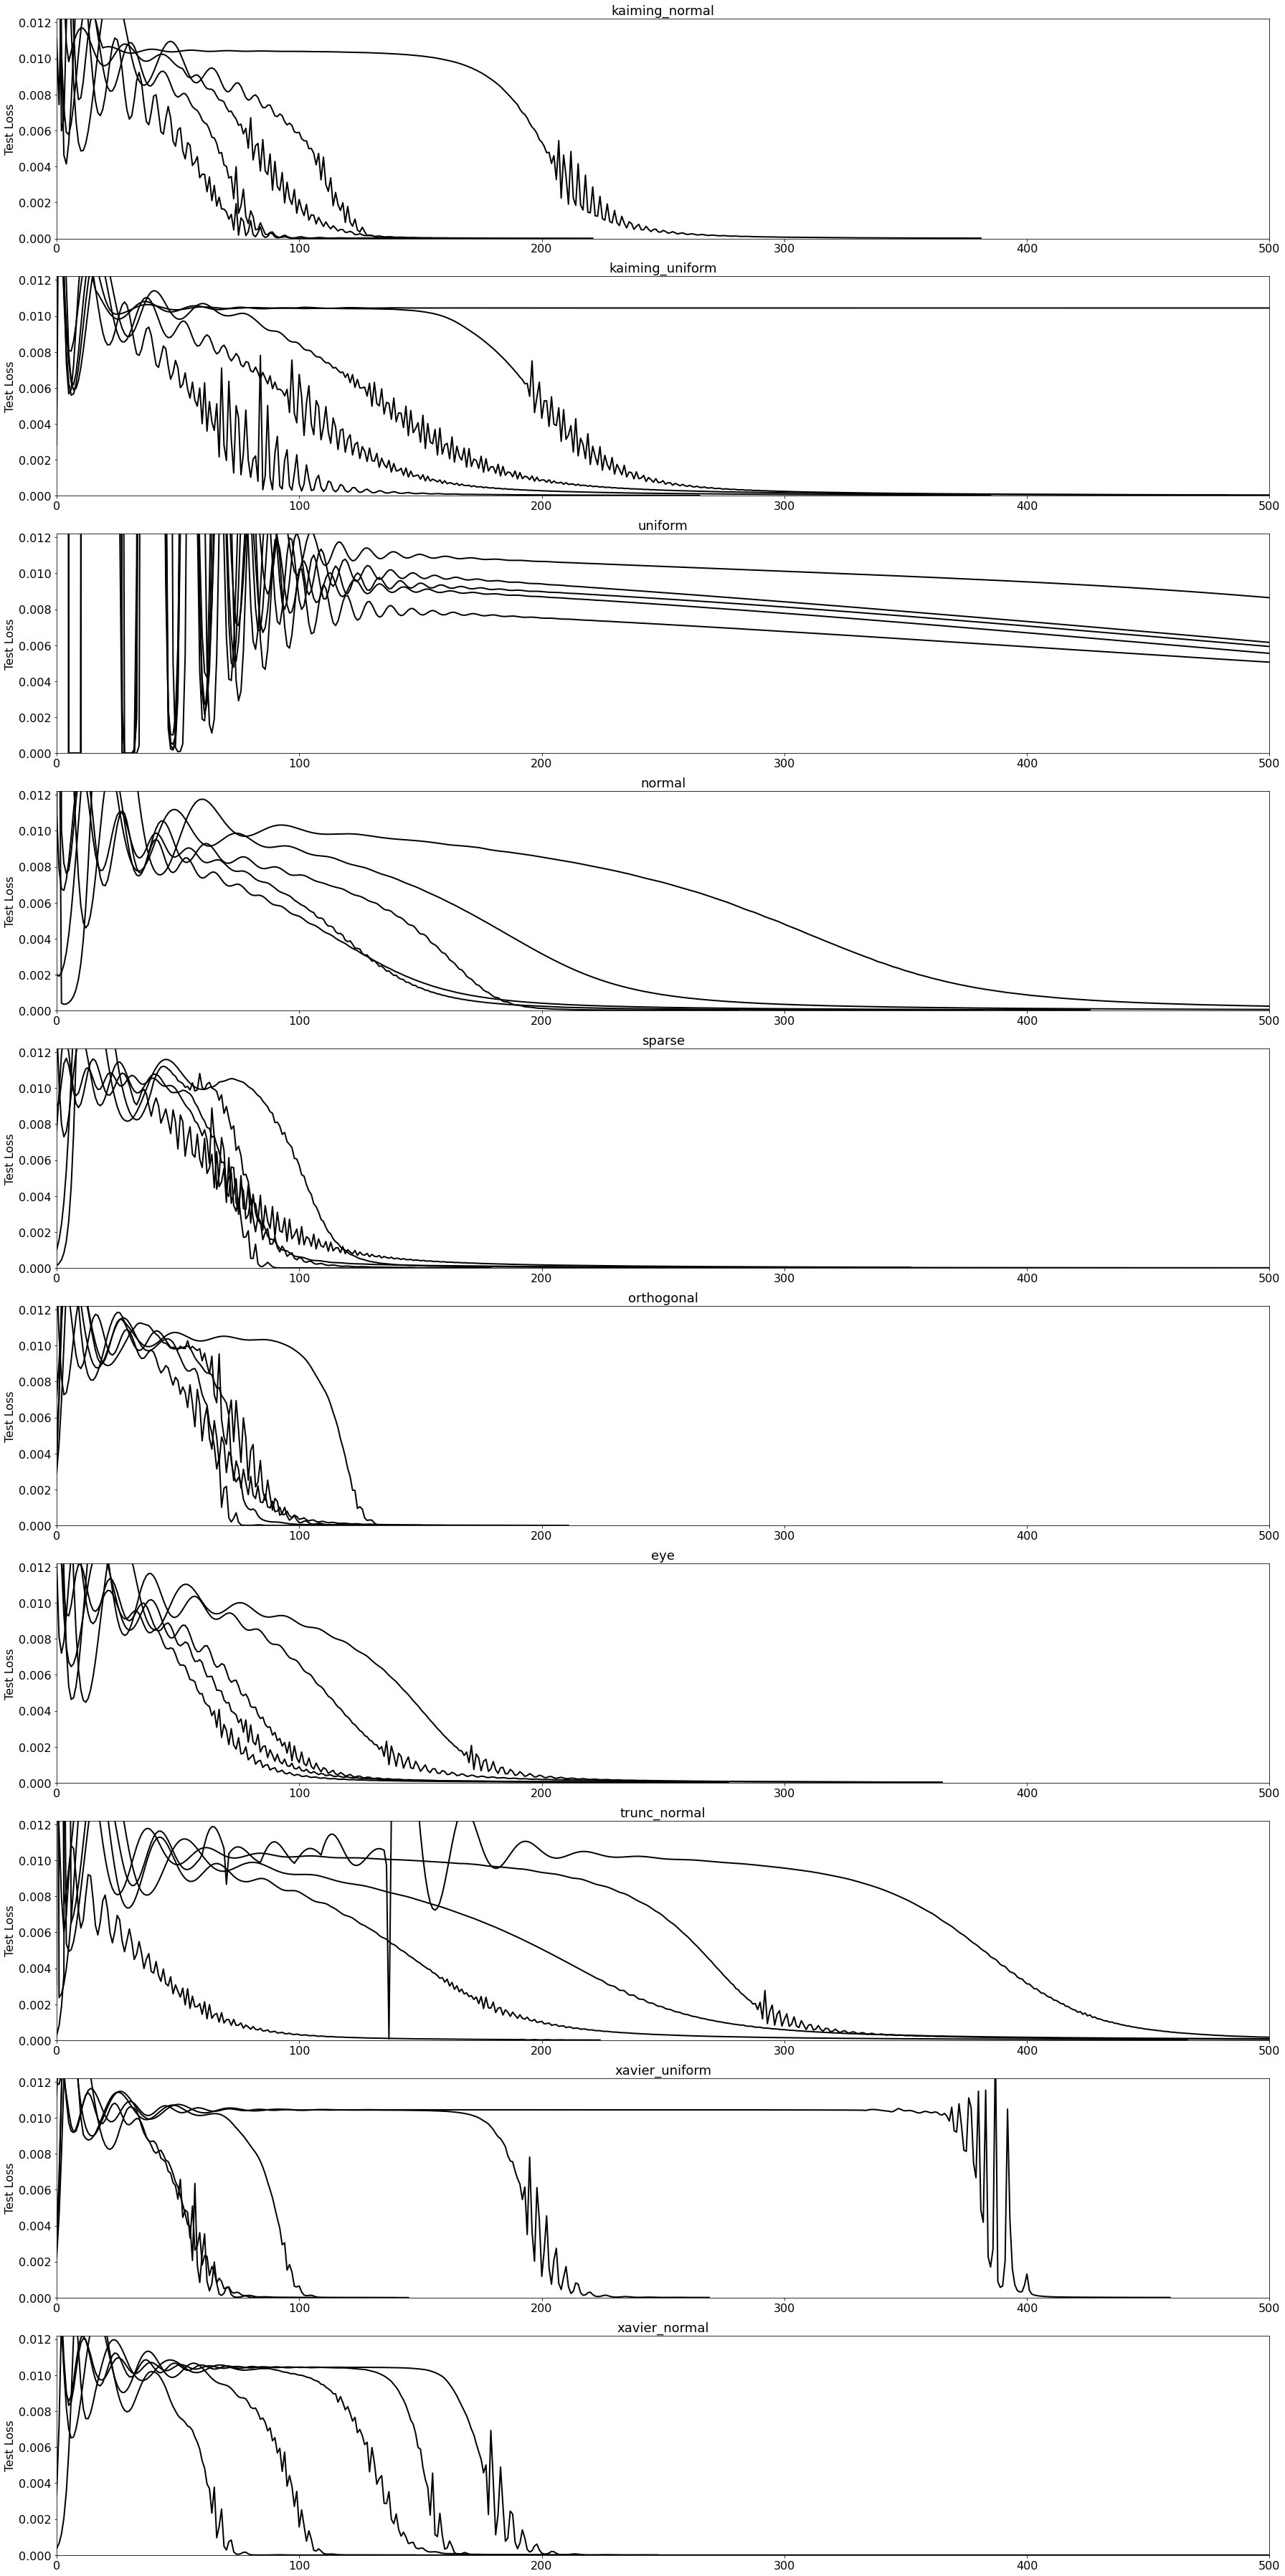

In [37]:
fname = Path("diversi_init_weights/stesso_dataset_gcn_trainable/10_methods_separati.png")
plot_onlyloss_ripetizioni_stesso_trial(xp, dot_key='model.init_weights', filename=fname, ylim=(0, 0.0122), xlim=(0,500))

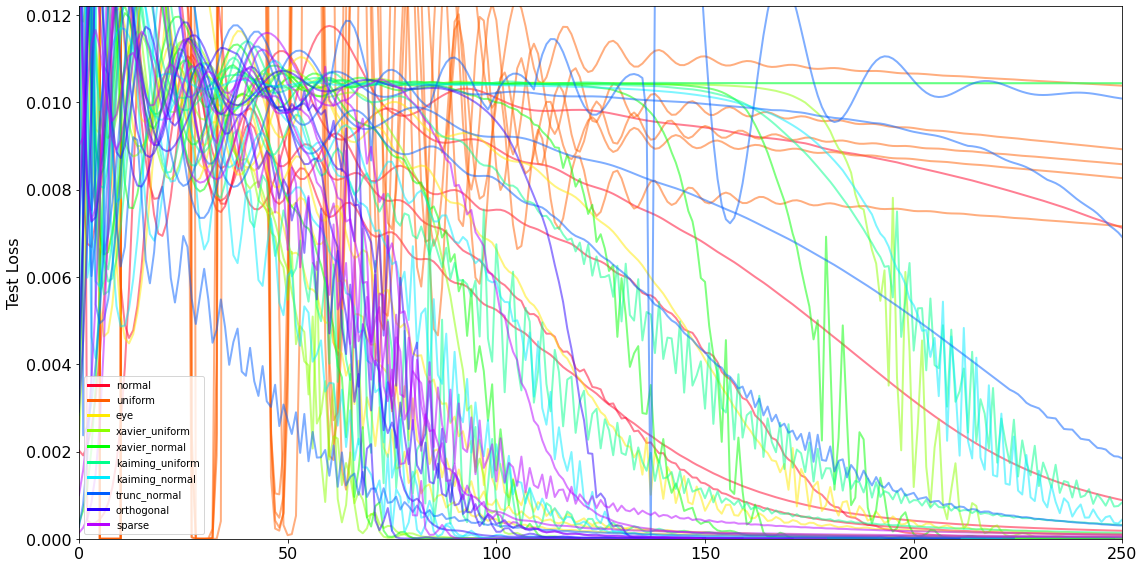

In [29]:
fname = Path("diversi_init_weights/stesso_dataset_gcn_trainable/10_methods.png")
plot_onlyloss_ripetizioni_stesso_trial_superimposed(xp, dot_key='model.init_weights', filename=None, ylim=(0, 0.0122), xlim=(0,250), lista_keys=metodi)

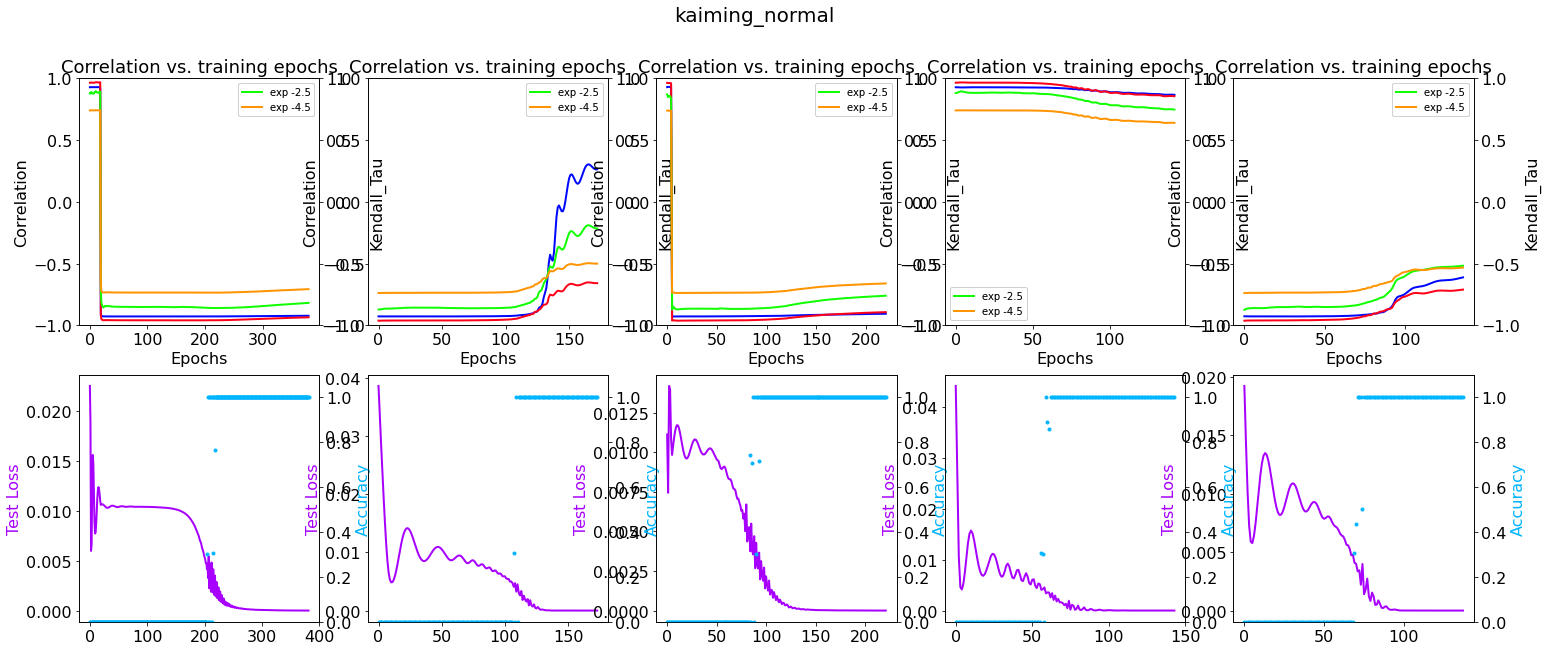

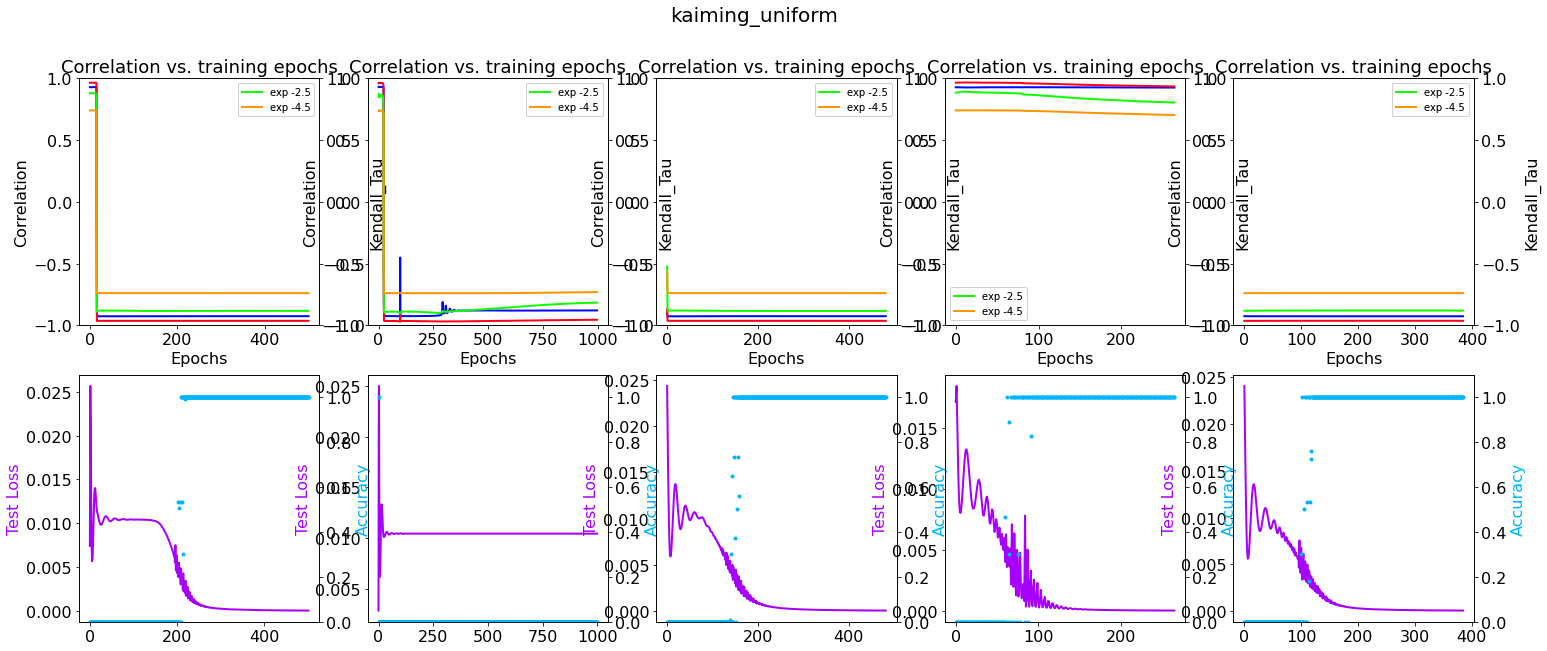

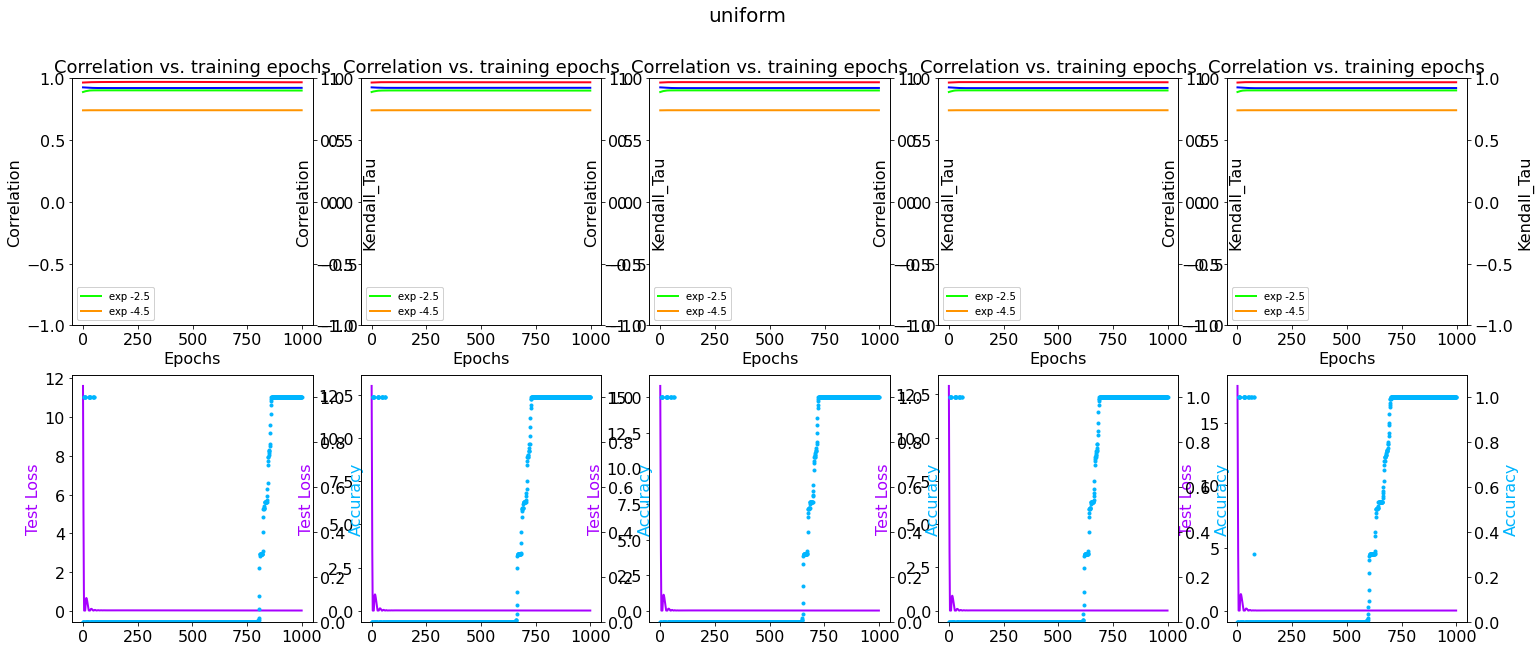

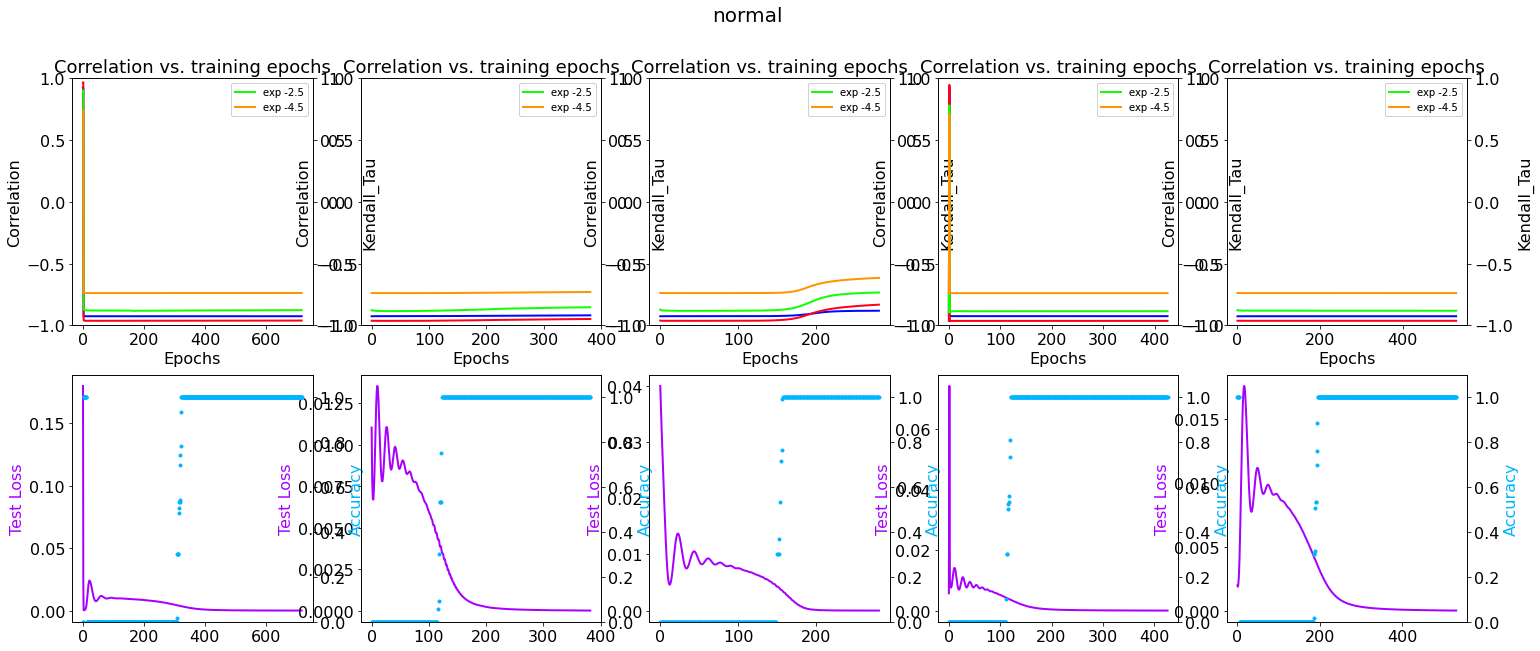

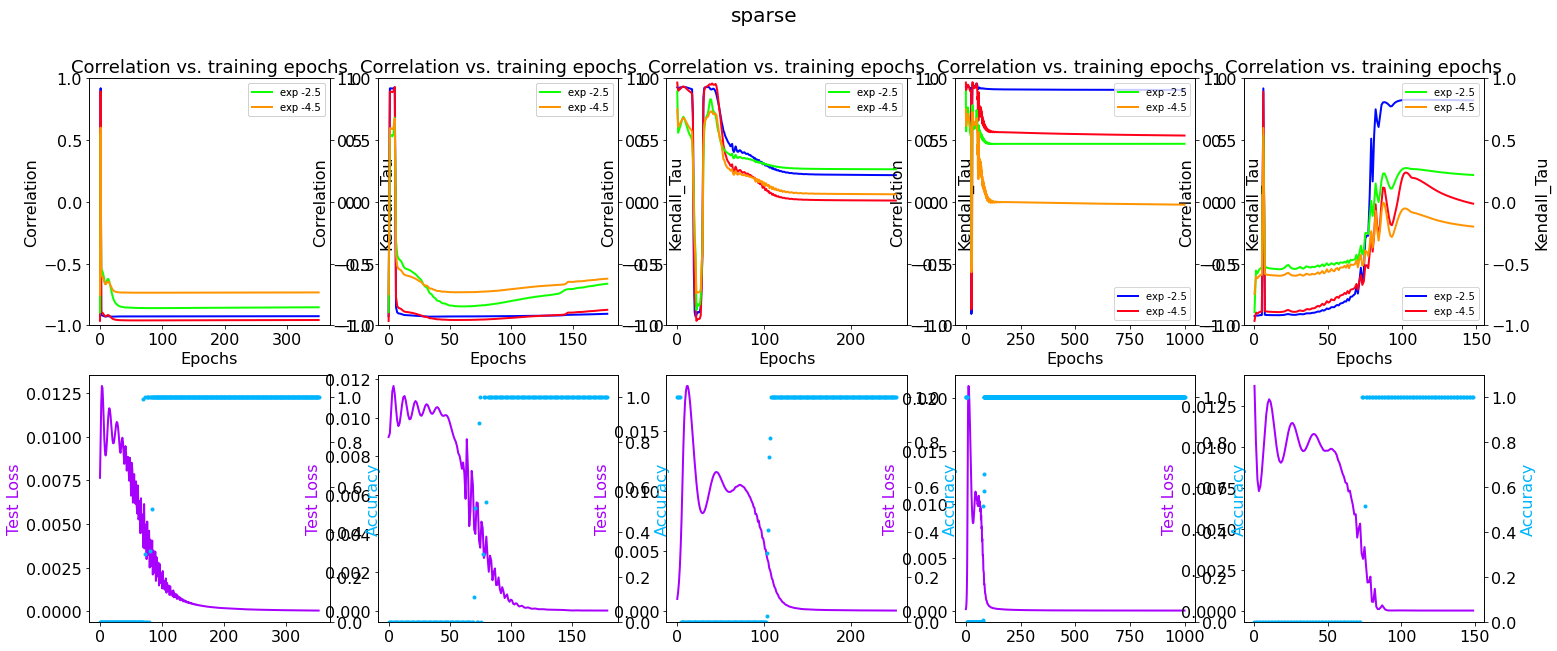

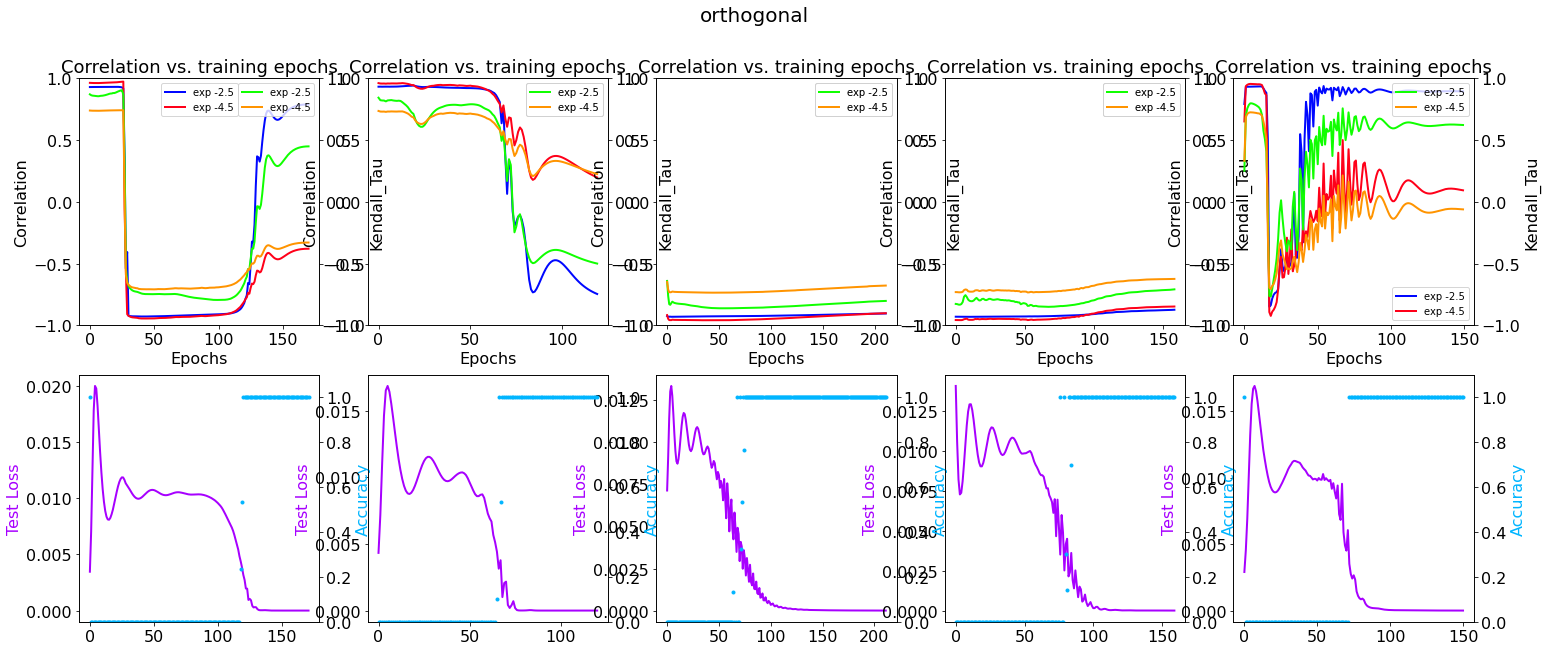

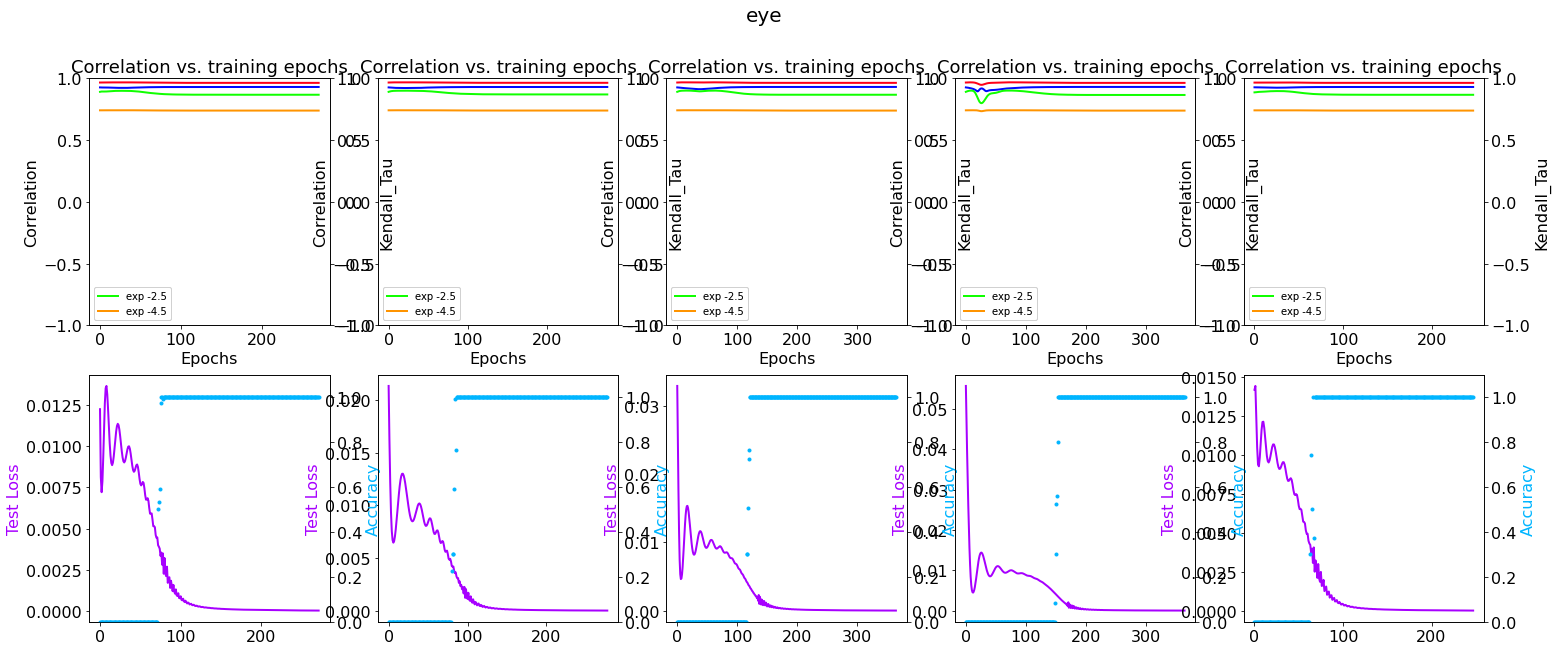

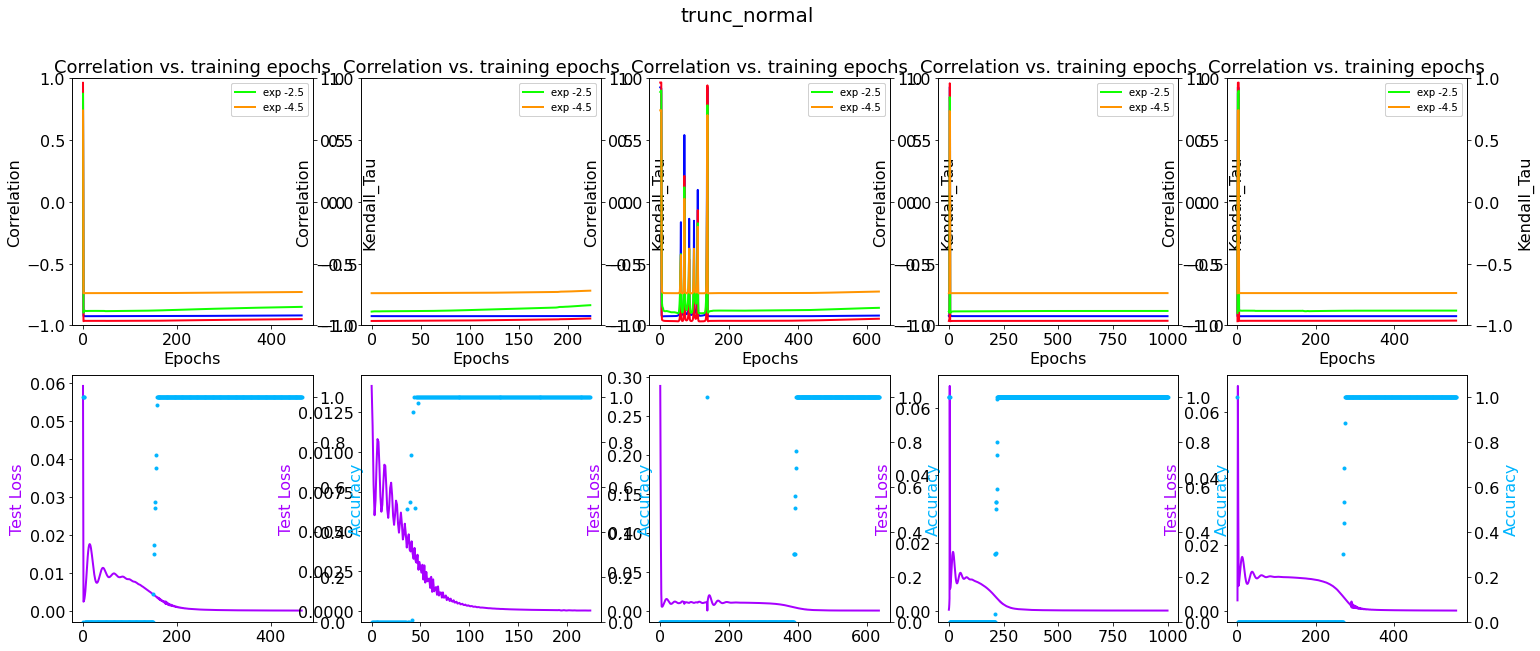

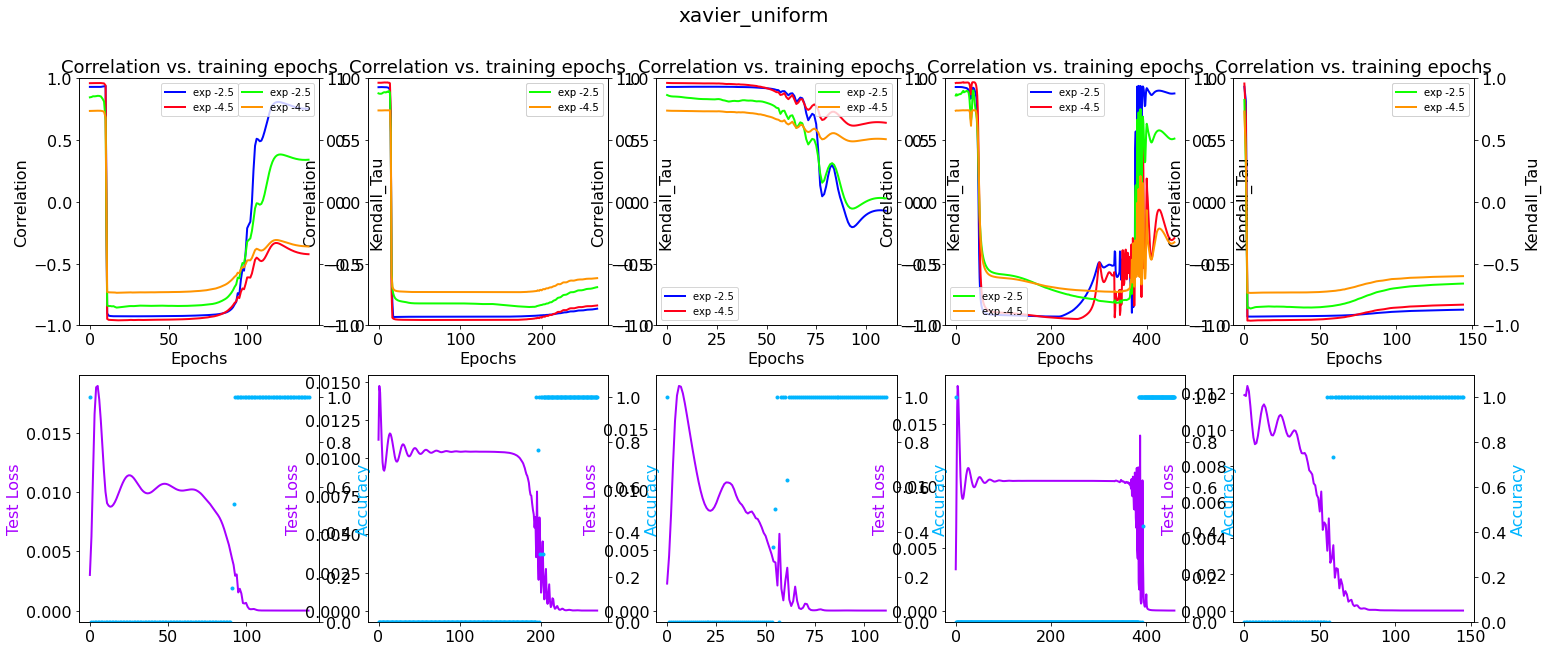

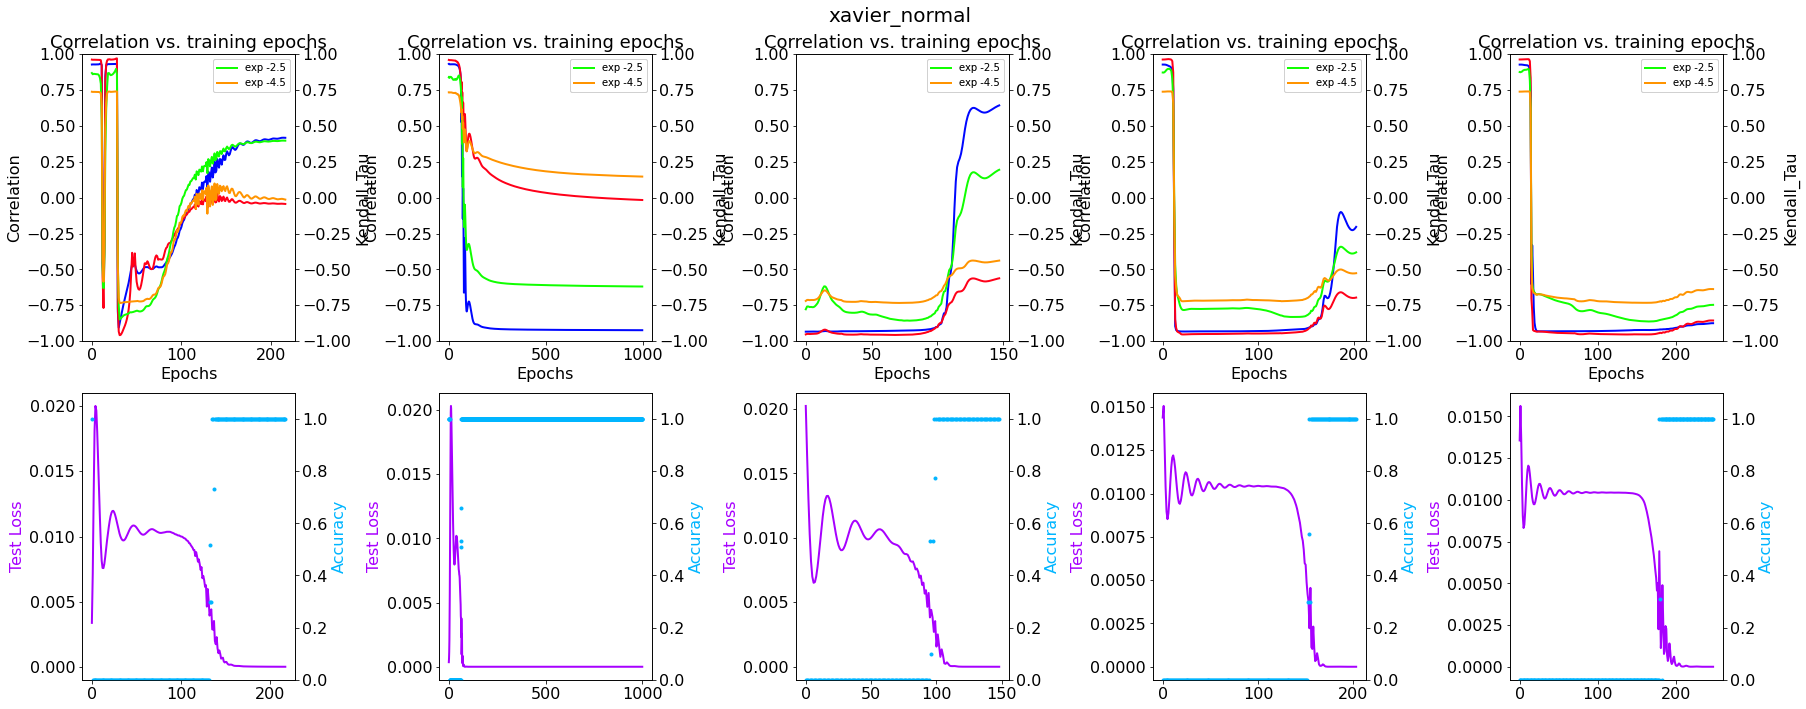

In [16]:
plot_ripetizioni_stesso_trial(xp, dot_key='model.init_weights', folder=None, rootsave=None)

# Grid search - dataset sempre diversi

## codice

In [3]:
config_class = Config(config_file)
trainer = Trainer(config_class)
experiments.global_config=config_class
experiments.global_trainer=trainer

diz_trials2 = {'model.init_weights': ['normal', 'uniform', 'eye', 'xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal', 'trunc_normal', 'orthogonal', 'sparse']*2}
gc2 = GridConfigurations(config_class, diz_trials2)
gc2.make_configs()
print(f"Farò {len(gc2.configs)} training.")

0 configurazioni saltate su 20
Farò 20 training.


In [ ]:
GS_different_weight_inits(trainer, gc2, train_with_same_dataset=False)

In [9]:
outfile = "df_configs_init_weights_stesso_dataset.csv"
gc2.config_dataframe.to_csv(outfile)

In [7]:
df = open_df_results(outfile)

Erano presenti 44 righe vuote


/home/daniele/Documenti/Progetti/Networks/Embednet/GridConfigurations.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_data.drop(columns=['device', 'logging'], inplace=True)


## Risultati

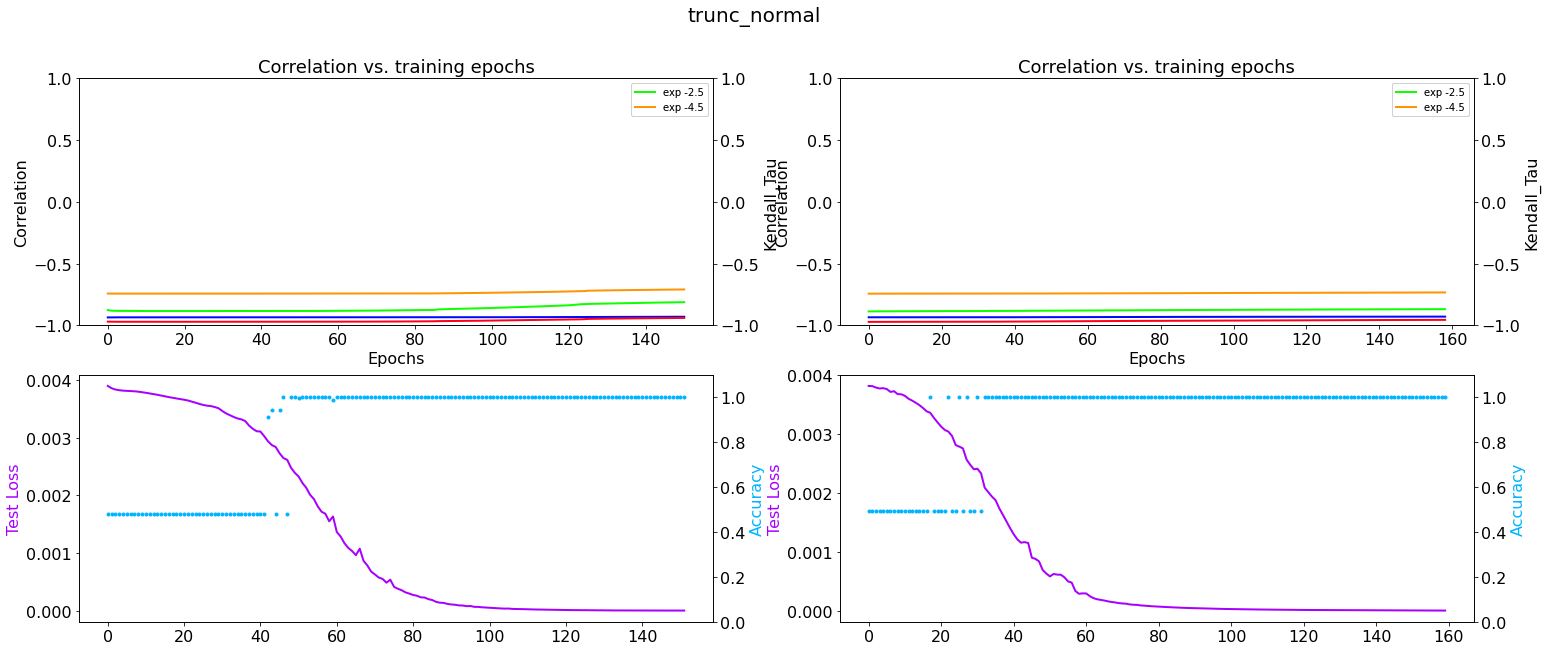

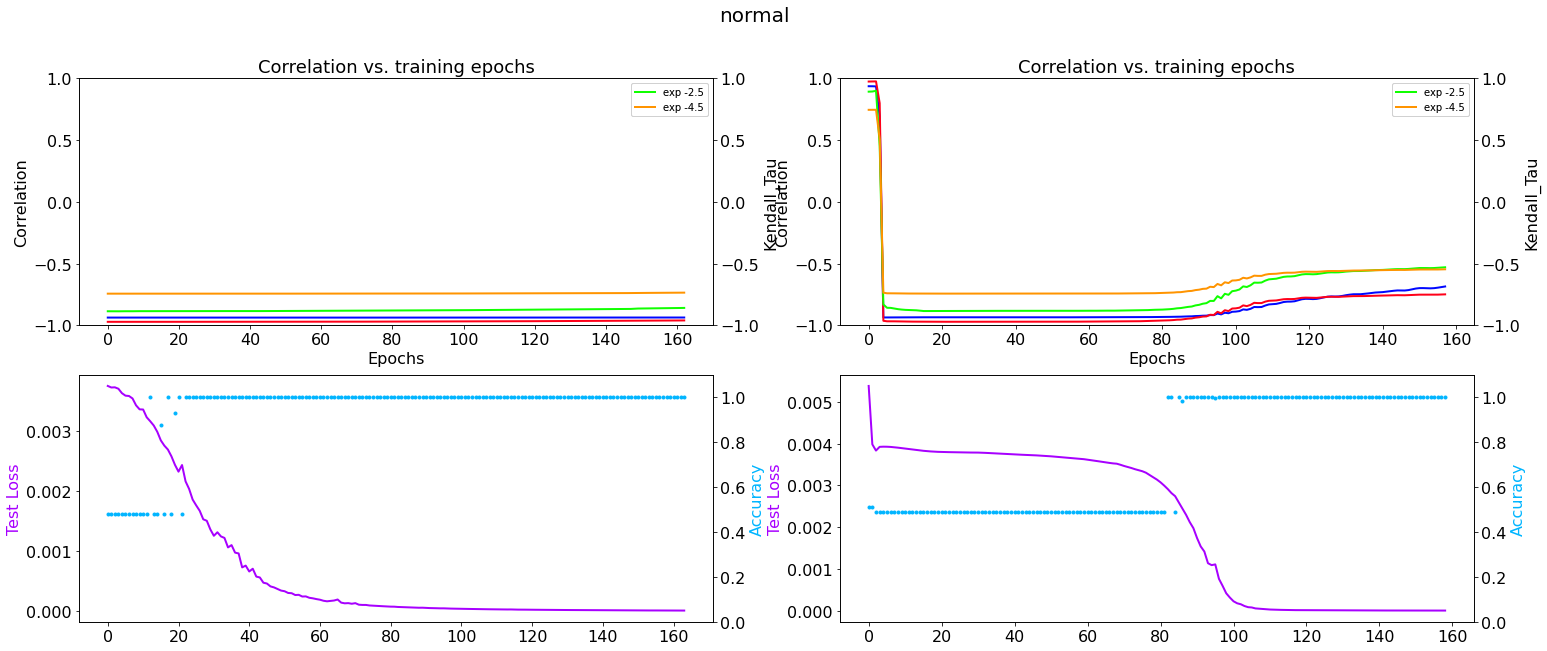

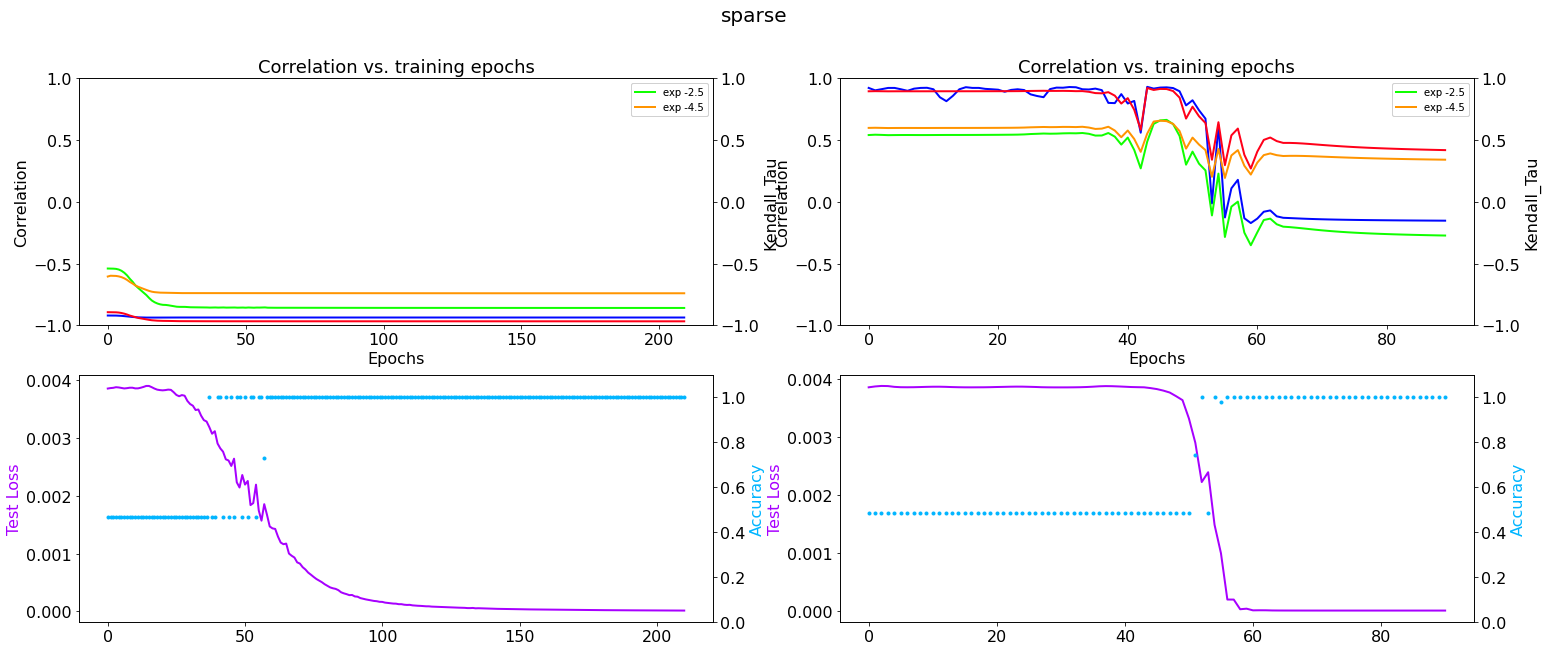

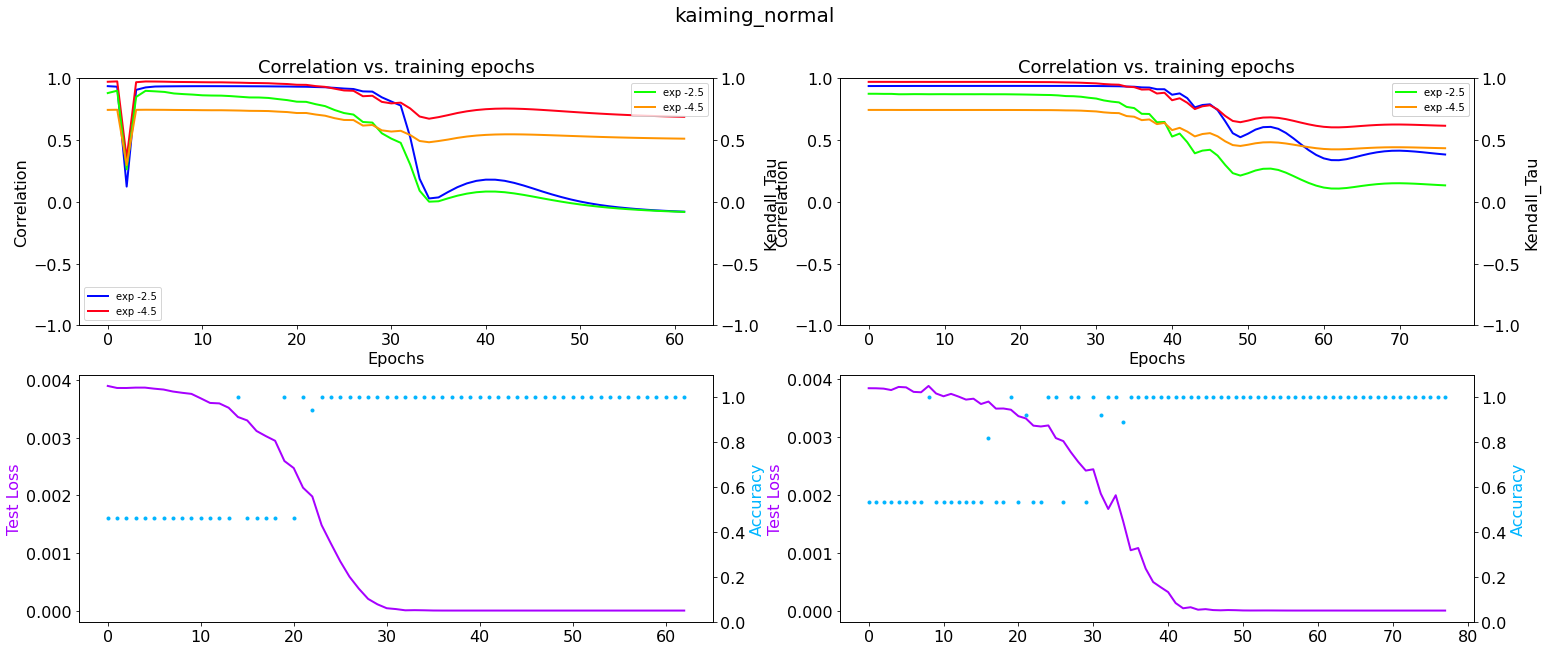

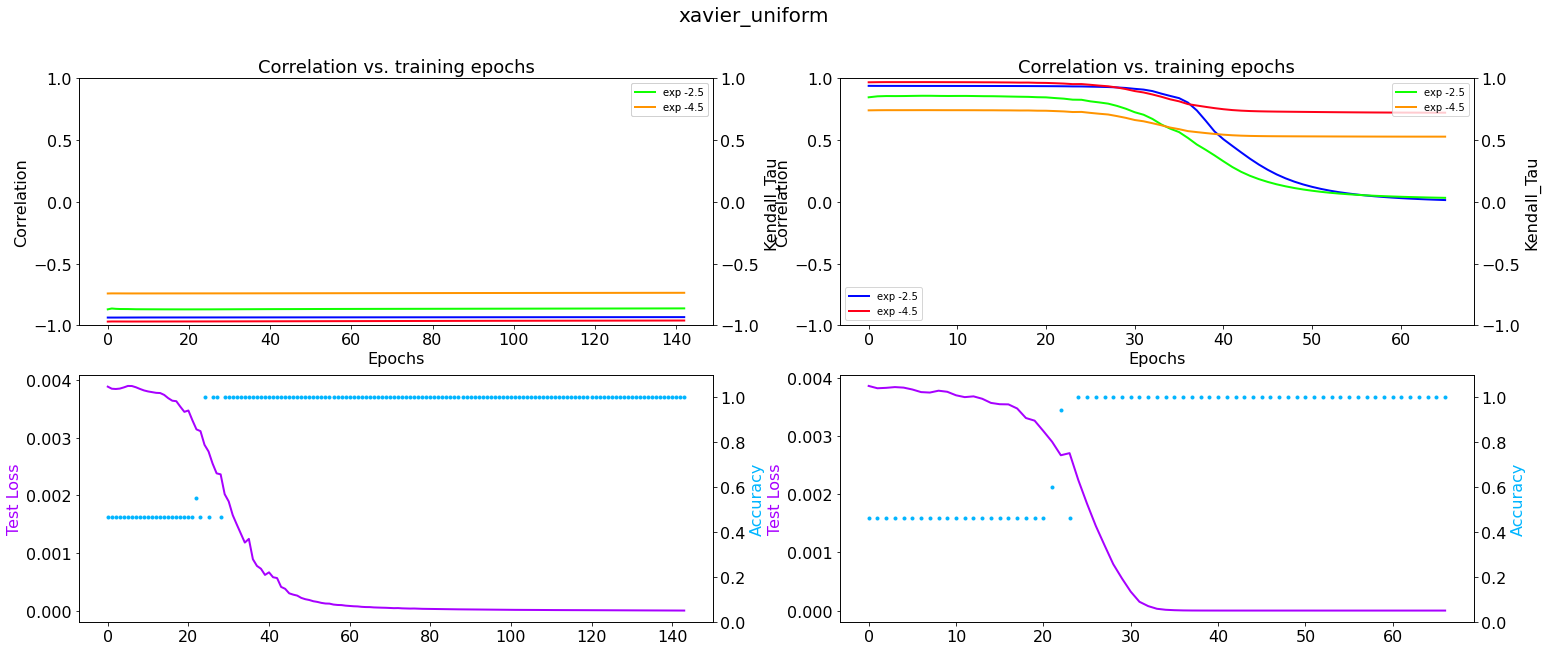

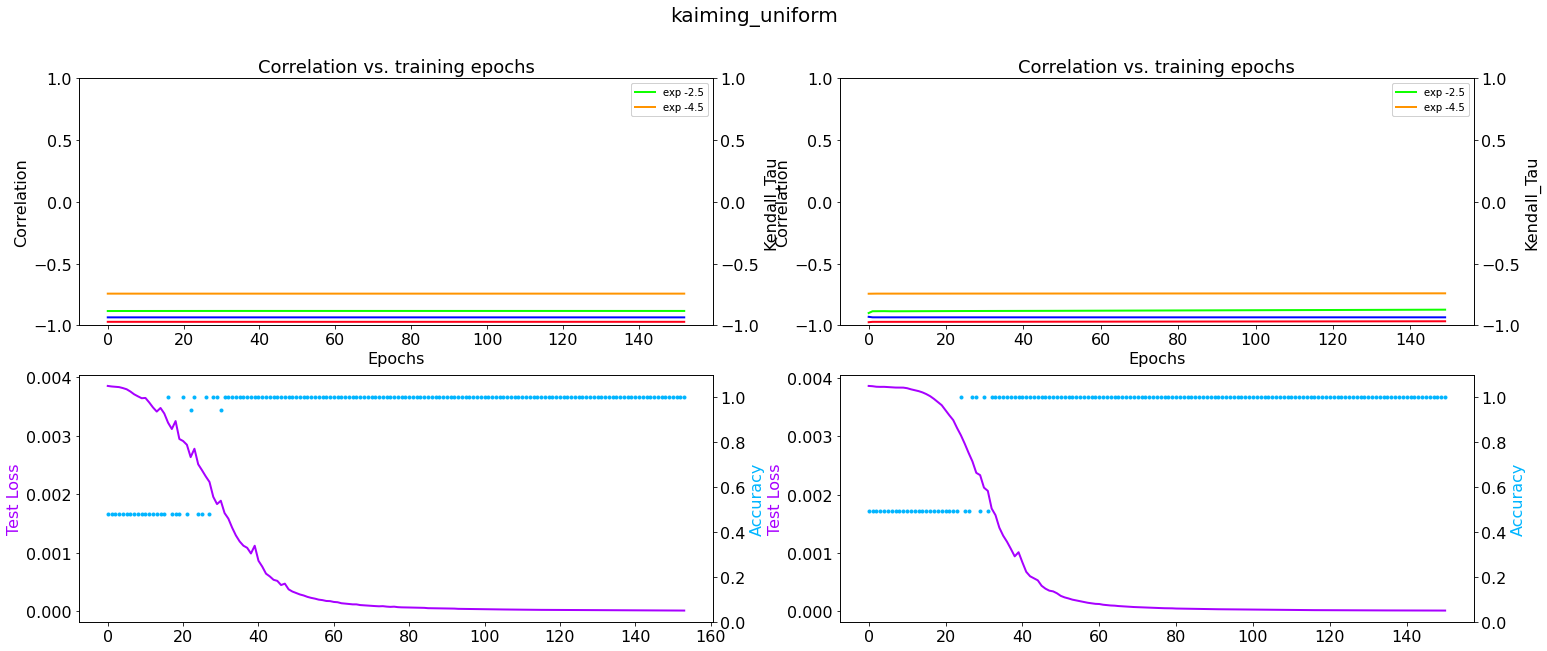

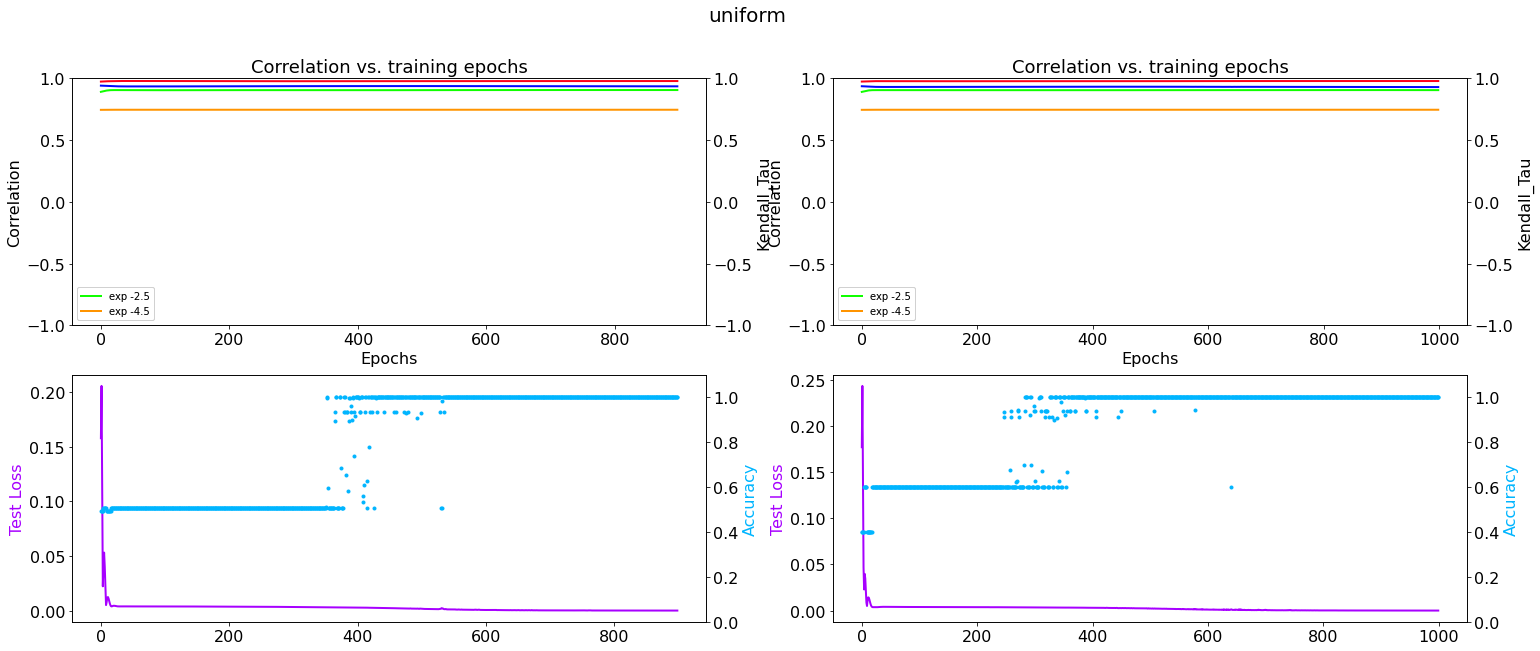

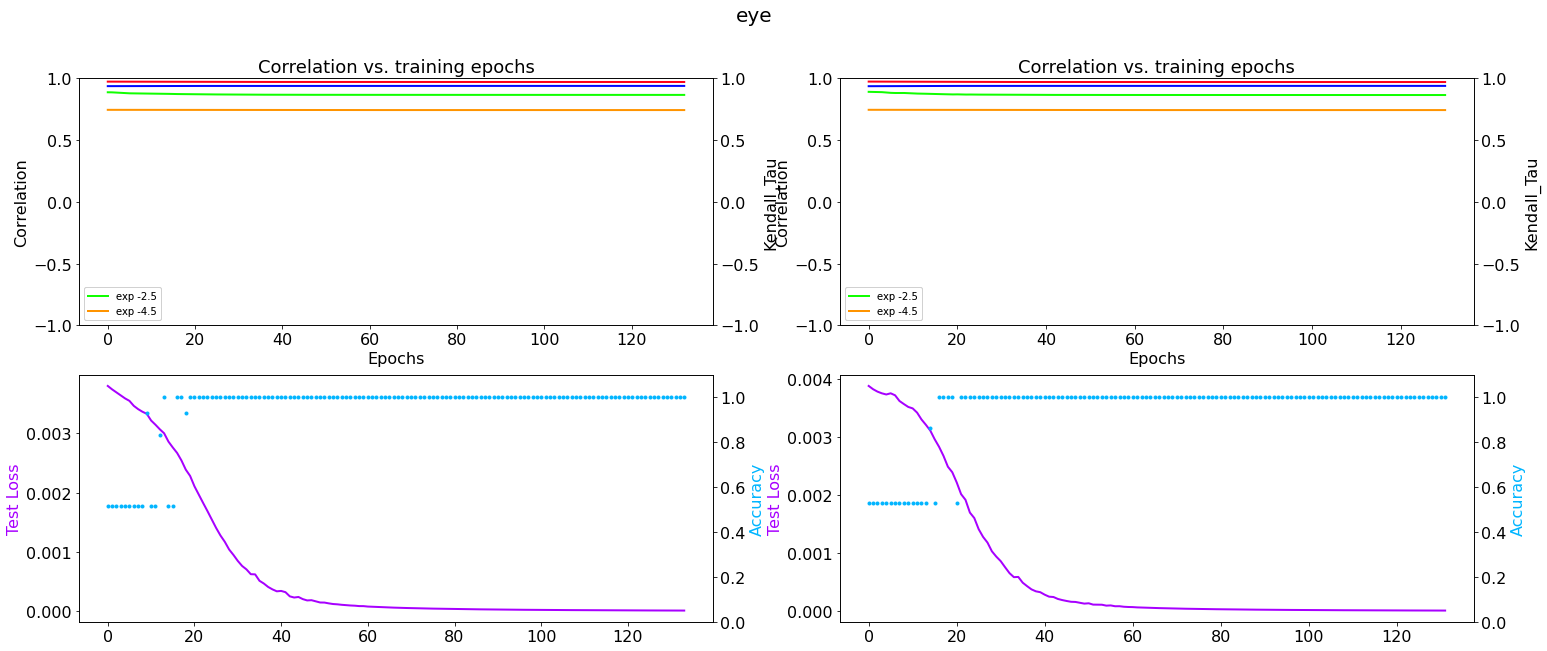

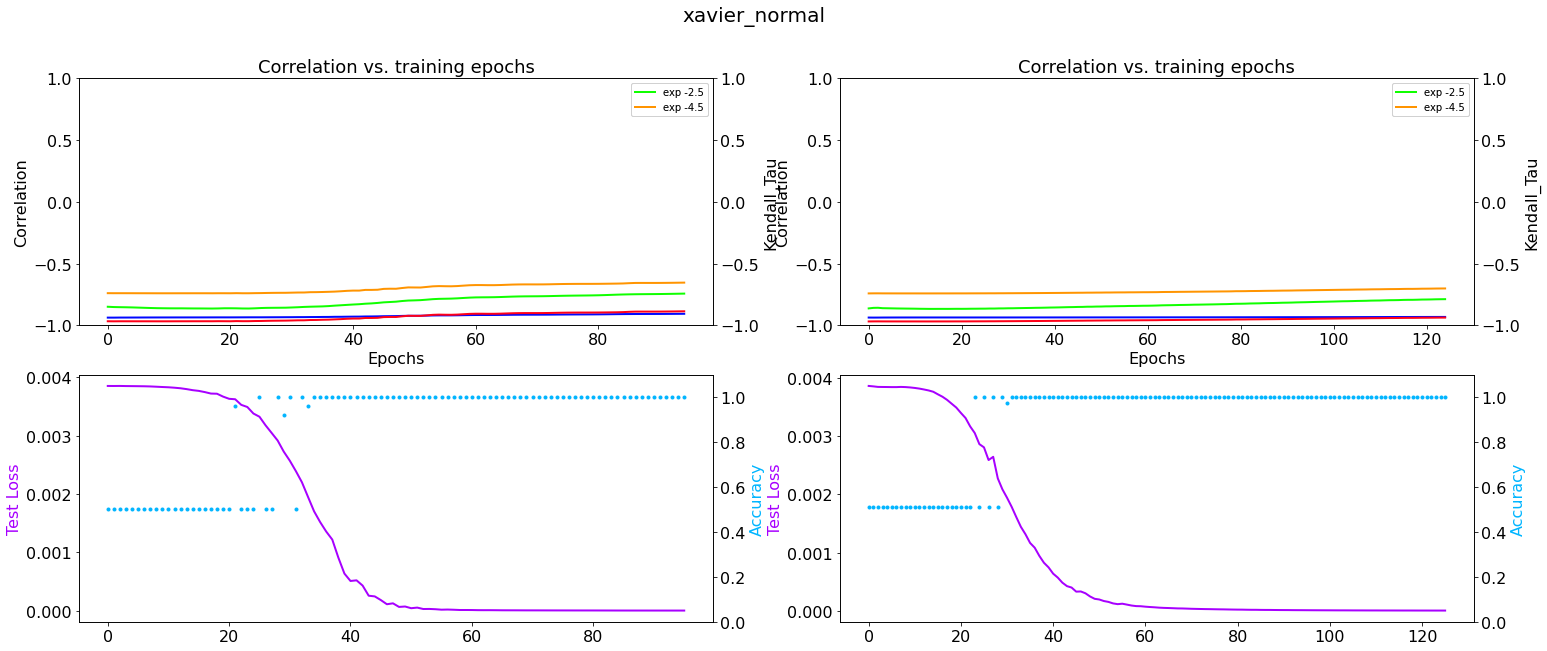

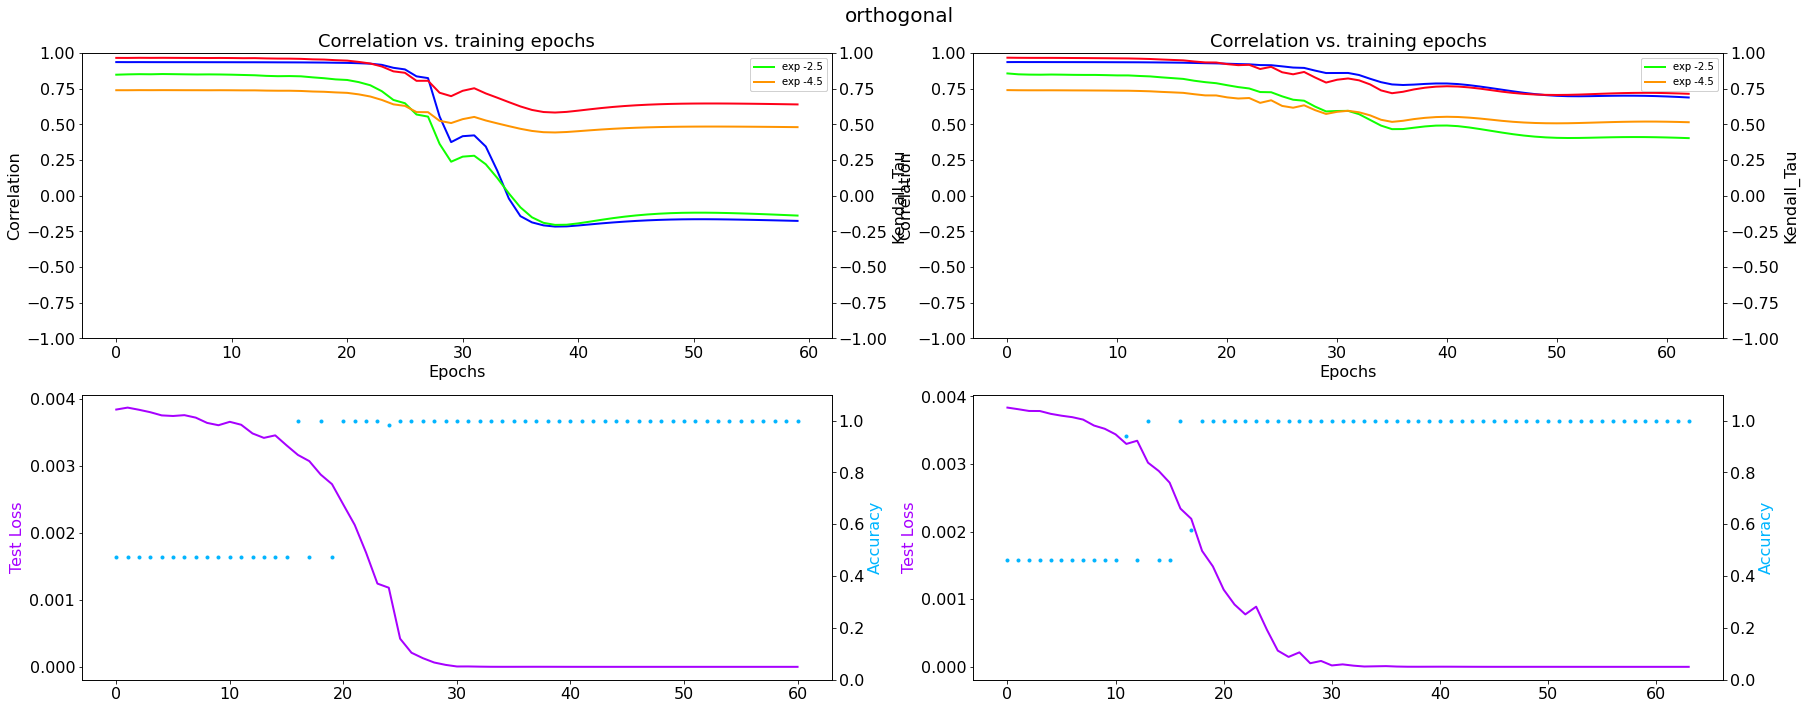

In [74]:
df = gc2.config_dataframe
folder = Path("diversi_init_weights/diversi_dataset_gcn_trainable/")
filename = Path("diversi_init_weights_diversi_dataset.png")
plot_ripetizioni_stesso_trial(df, diz_trials2, 'model.init_weights', filename)

### I risultati mostrano che alcune inizializzazioni lasciano la correlazione iniziale invariata mentre altre la azzerano: queste ultime sono le inizializzazioni specifiche adottate per migliorare la retro propagazione del gradiente, di contro abbiamo visto che quando lasciamo invariati i pesi, la correlazione iniziale è alta, perciò questo dimostra in maniera graduale che più il gradiente arriva ai layer precedenti e più questa informazione porta i pesi a cambiare il node embedding verso una distribuzione che non è correlata con la sequenza di grado

In [27]:
from scipy.stats import kendalltau

In [30]:
x1 = [12, 2, 1, 12, 2]
x2 = [1, 4, 7, 1, 0]
tau, p_value = kendalltau(x1, x2)
tau
#p_value

-0.4714045207910316

# GCN layers freezed - Dataset diversi

## Codice

In [26]:
config_file = "configurations/classification_cm.yml"
config_class = Config(config_file)
trainer = Trainer(config_class)
experiments.global_config=config_class
experiments.global_trainer=trainer

diz_trials3 = {'model.init_weights': ['normal', 'uniform', 'eye', 'xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal', 'trunc_normal', 'orthogonal', 'sparse']*4}
gc3 = GridConfigurations(config_class, diz_trials3)
gc3.make_configs()
print(f"Farò {len(gc3.configs)} training.")

0 configurazioni saltate su 40
Farò 40 training.


In [ ]:
GS_different_weight_inits(trainer, gc3, train_with_same_dataset=False)

In [ ]:
# non l'avevo salvato, se voglio in caso devo rigirarlo
outfile = "df_configs_init_weights_diversi_dataset_gcn_freezed.csv"
gc3.config_dataframe.to_csv(outfile)

## Risultati

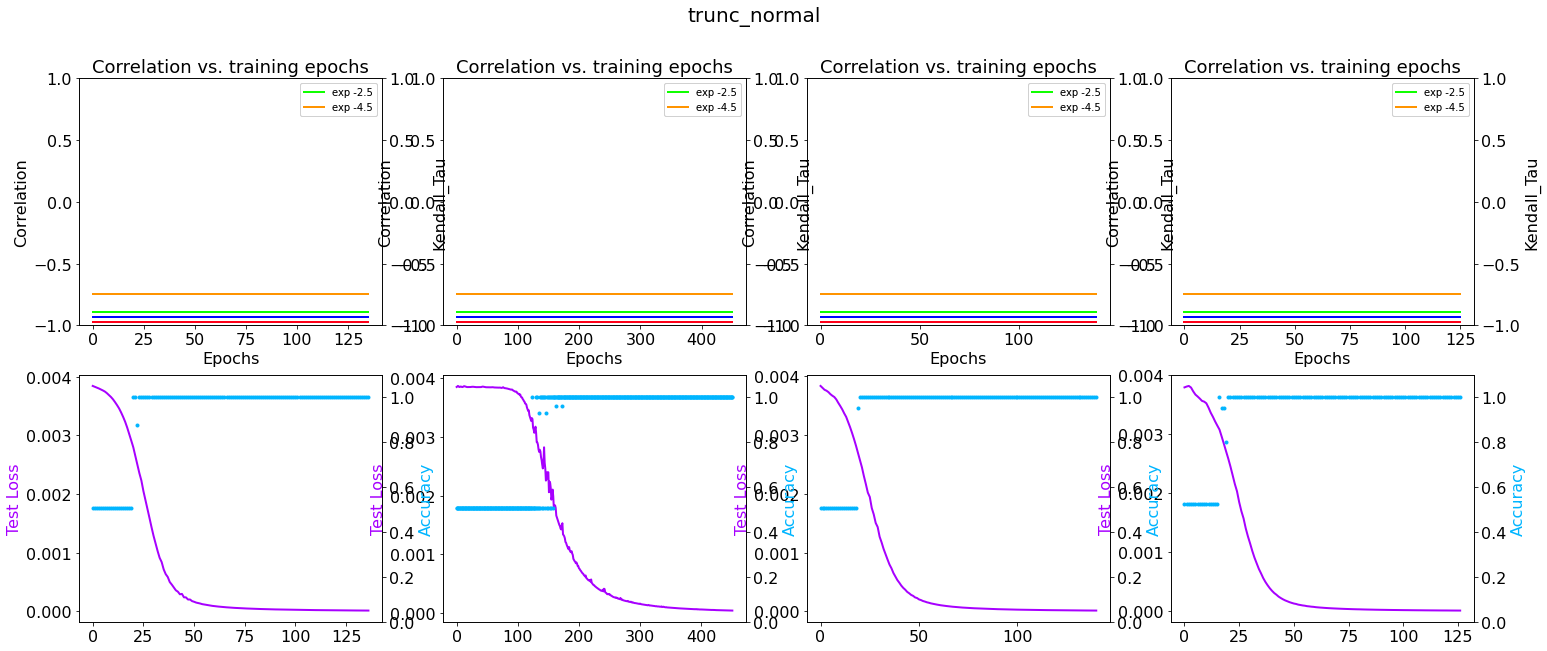

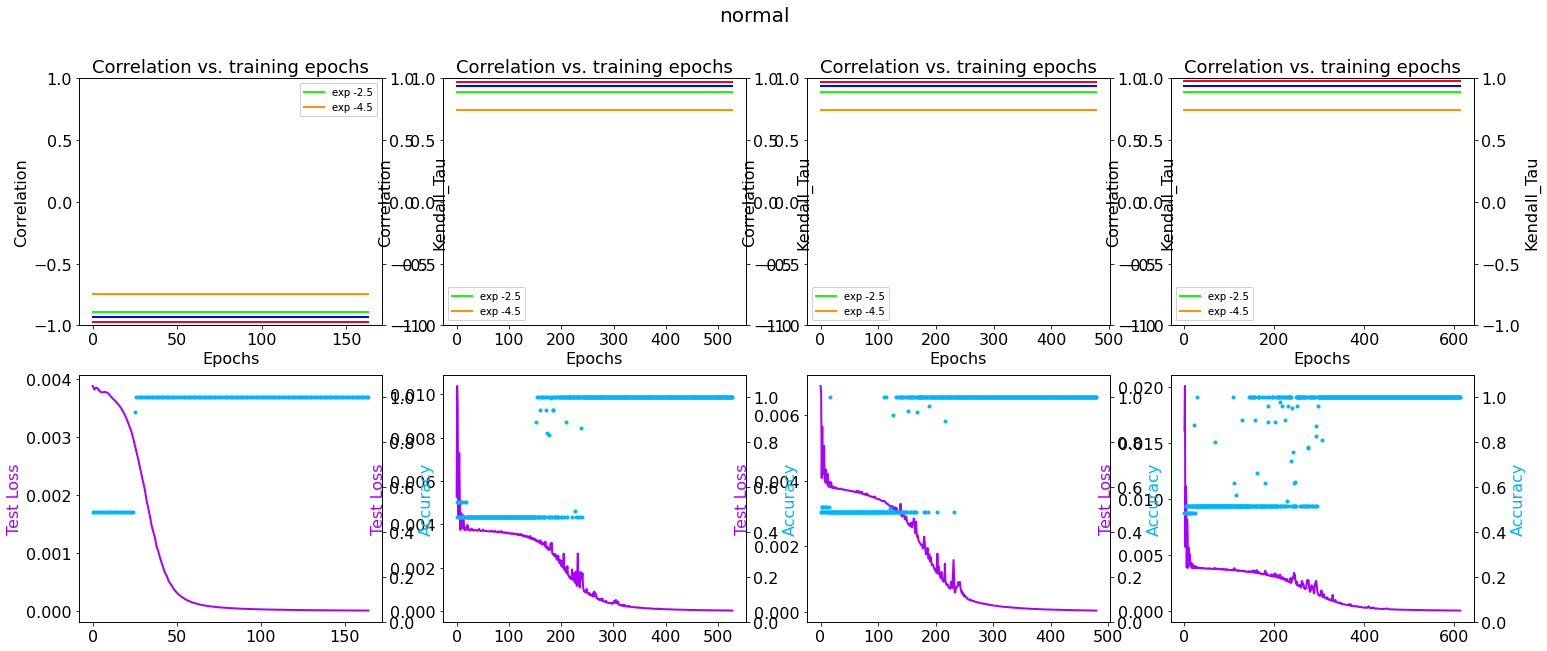

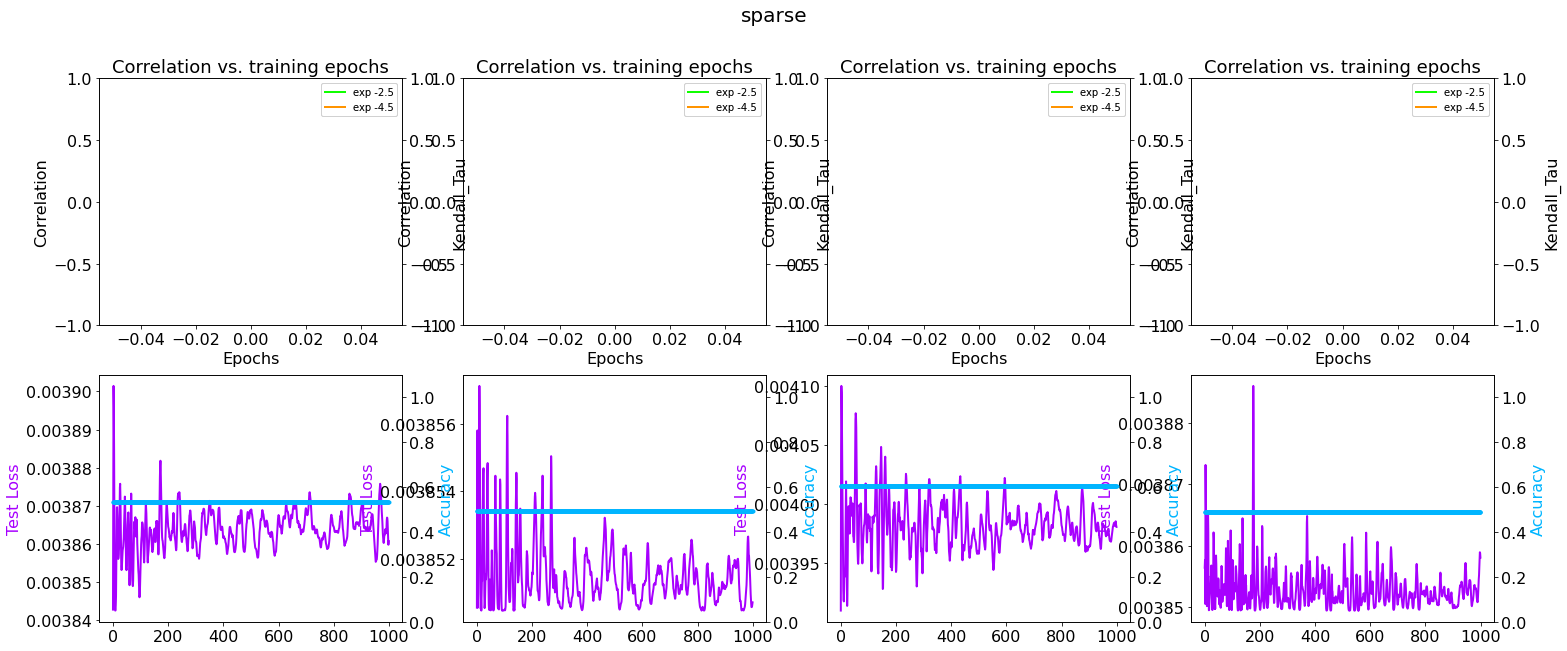

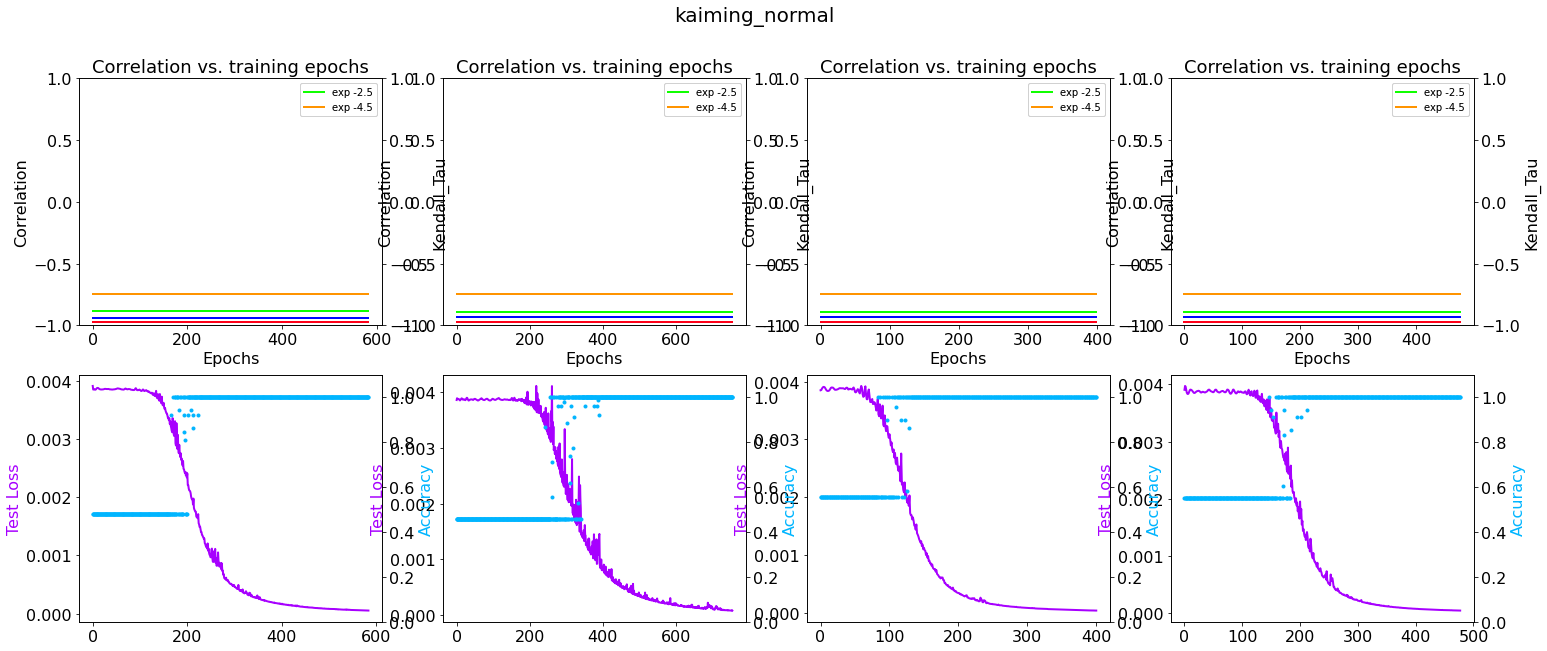

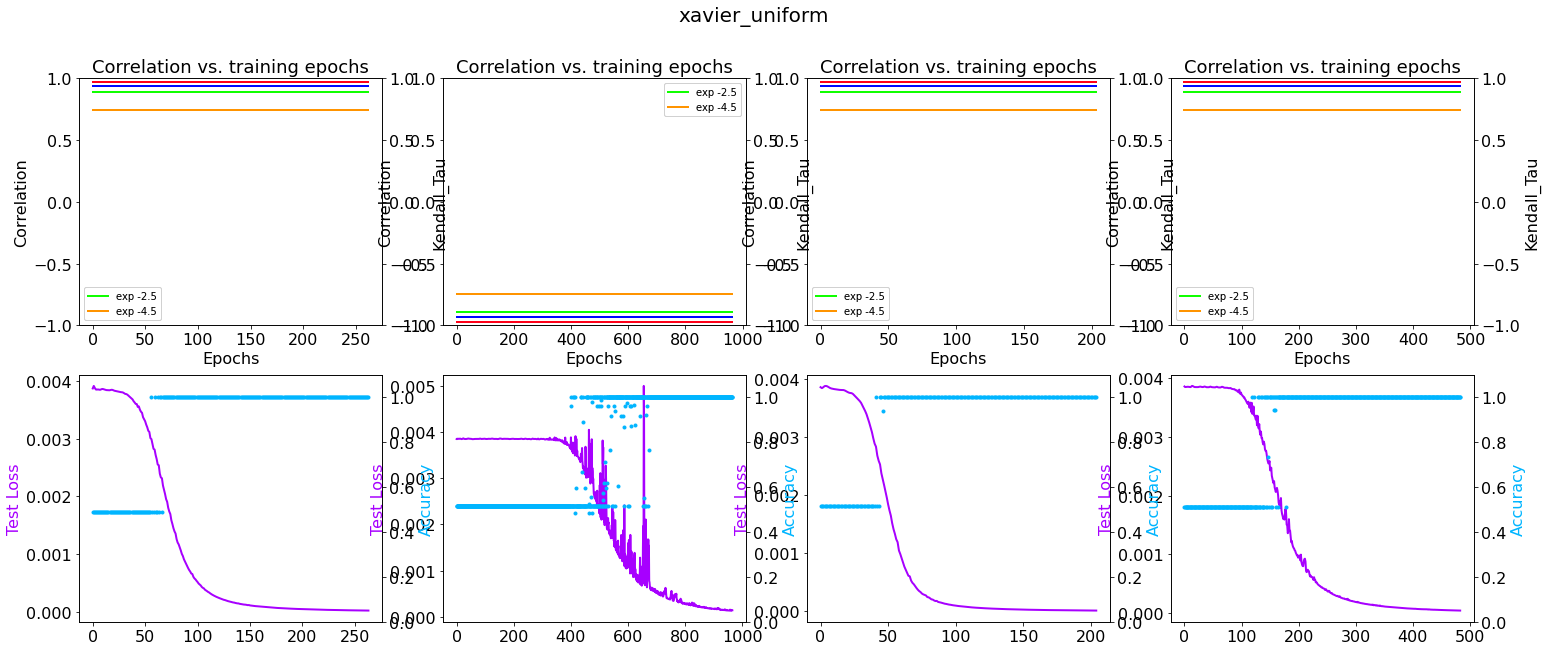

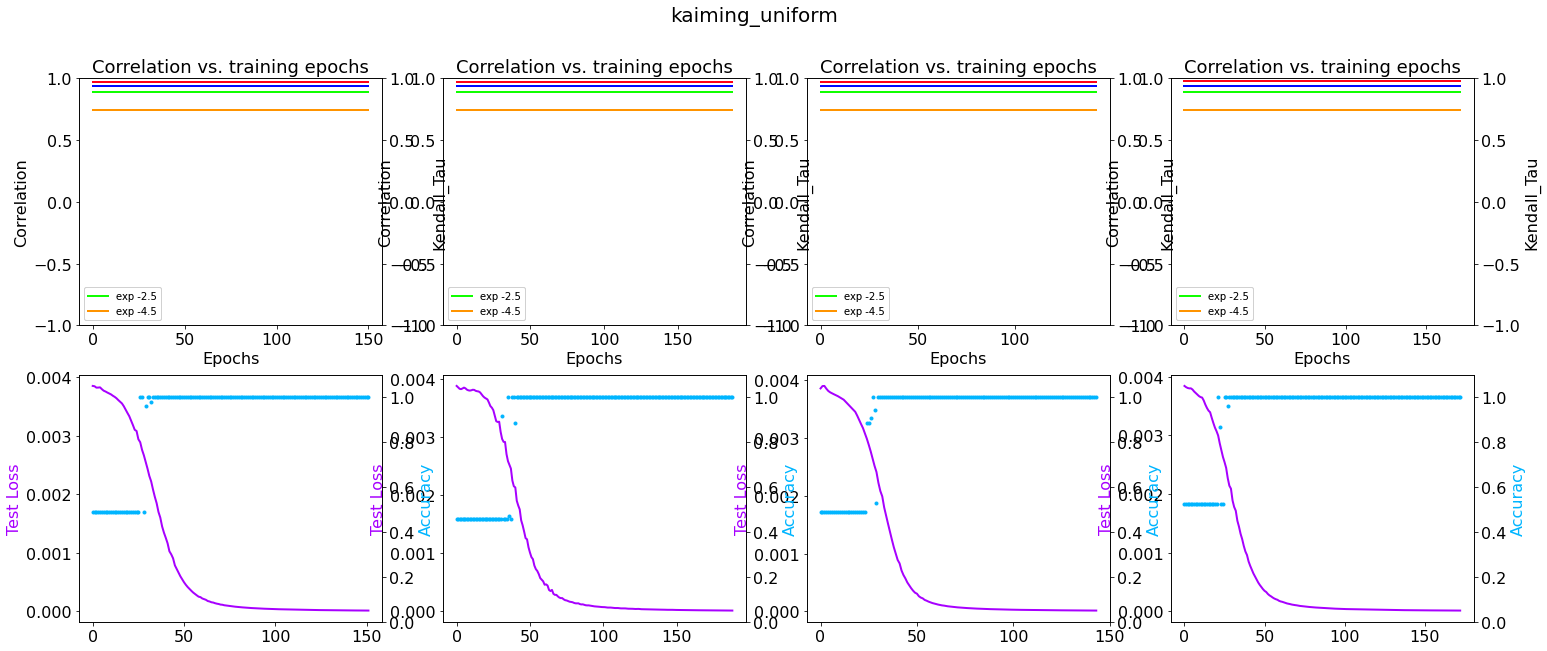

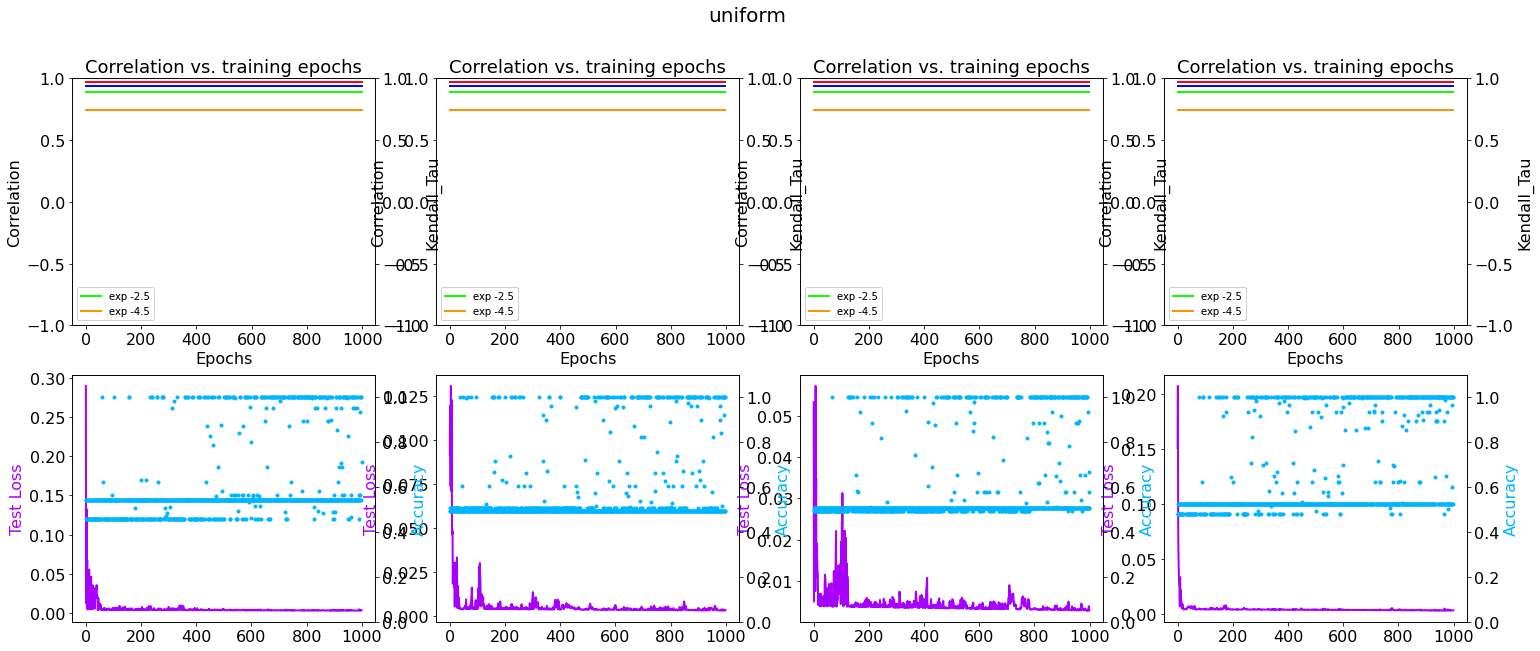

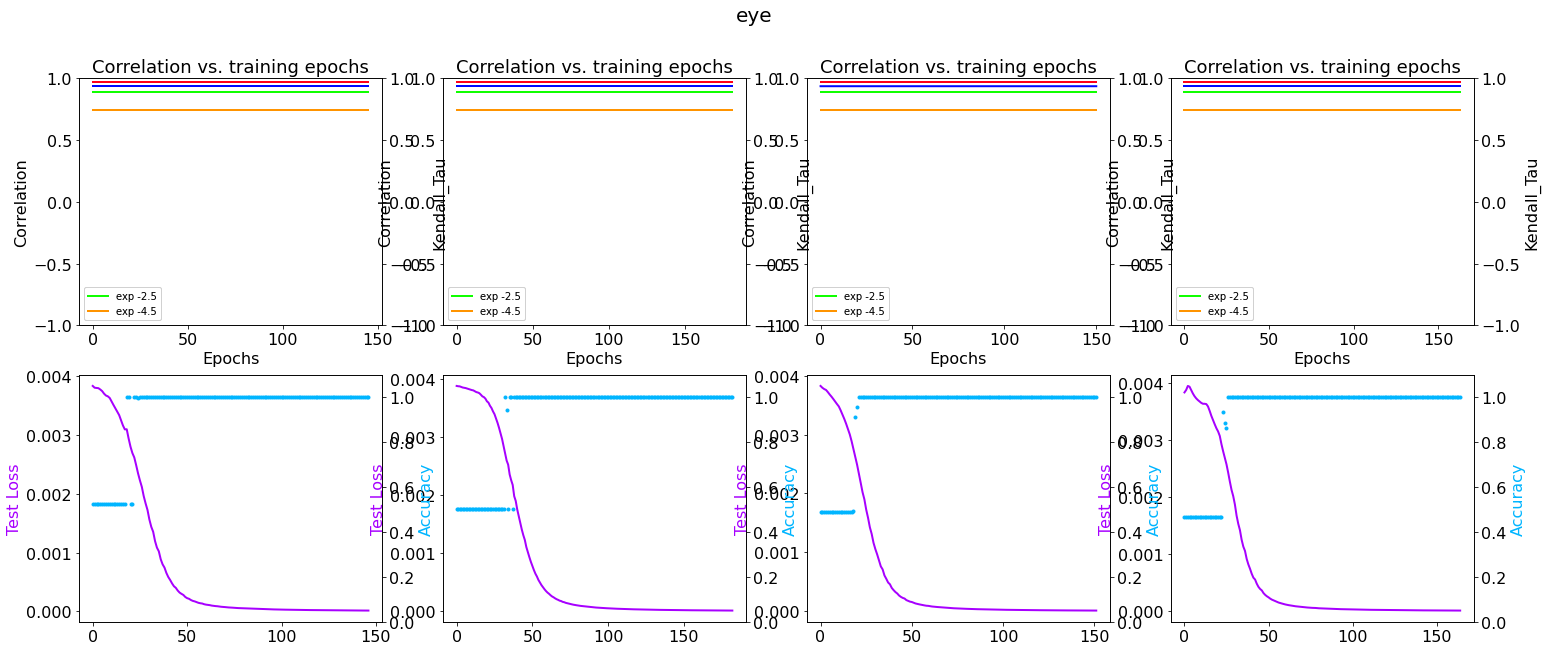

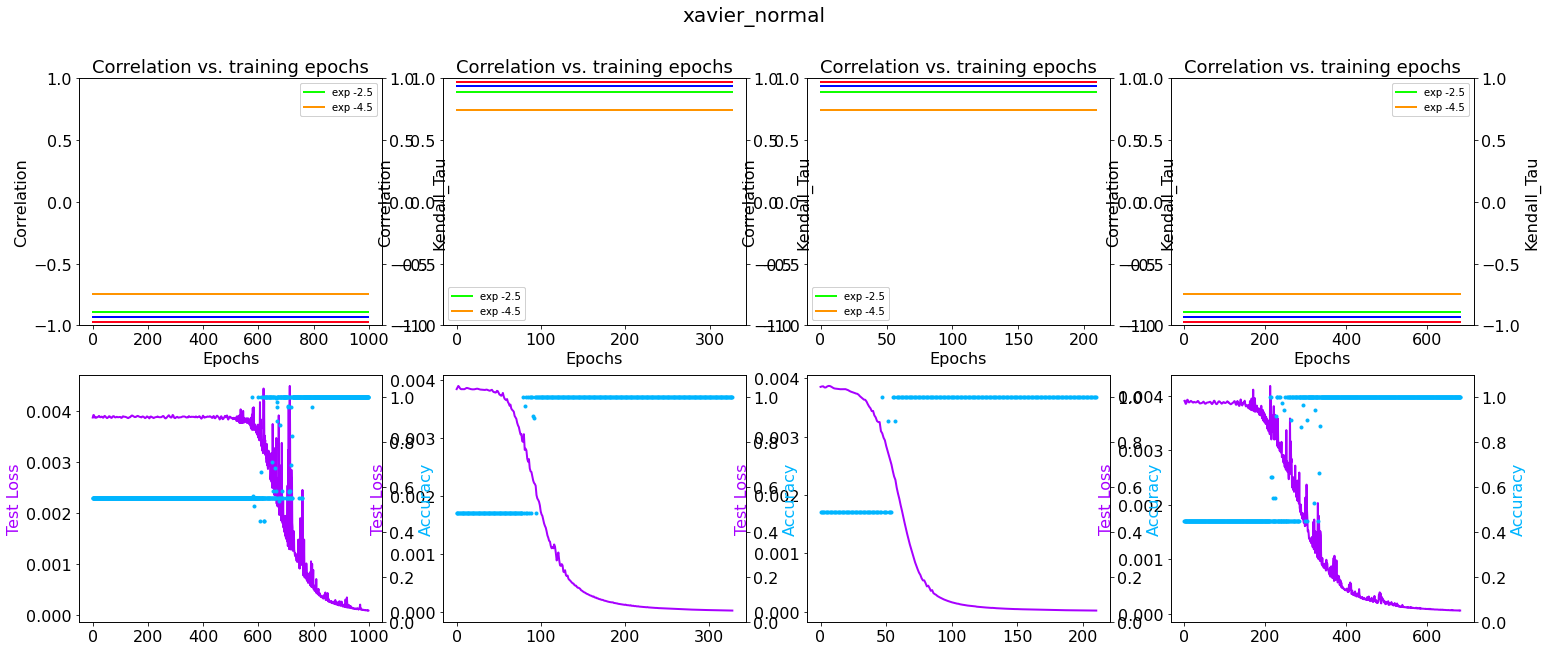

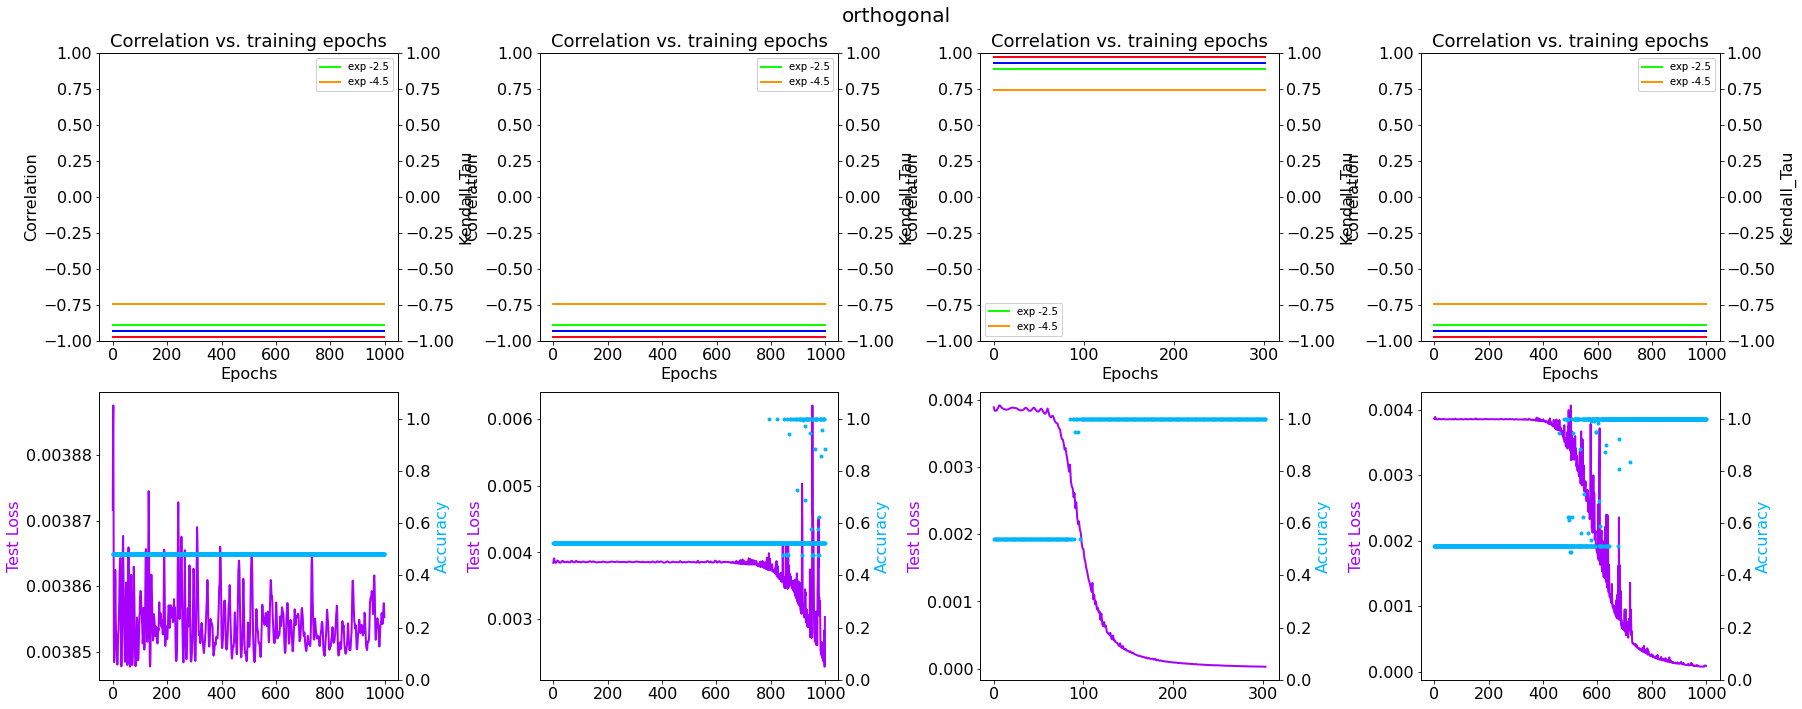

In [79]:
folder = Path("diversi_init_weights/diversi_dataset_gcn_freezed/")
plot_ripetizioni_stesso_trial(df=gc3.config_dataframe, diz_trials=diz_trials3, dot_key='model.init_weights', folder=folder)

### Solo test loss

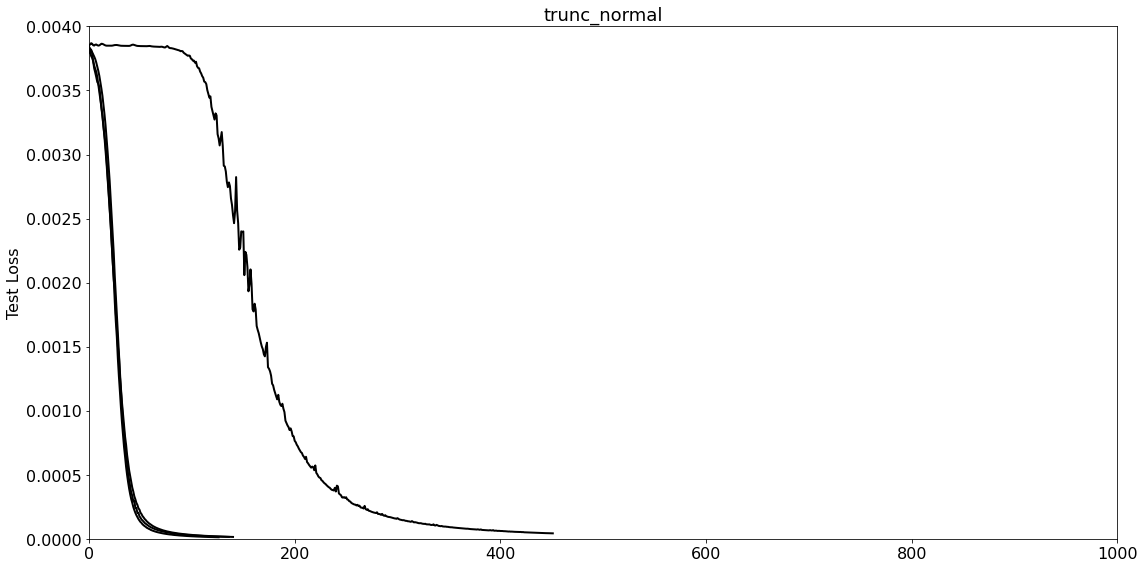

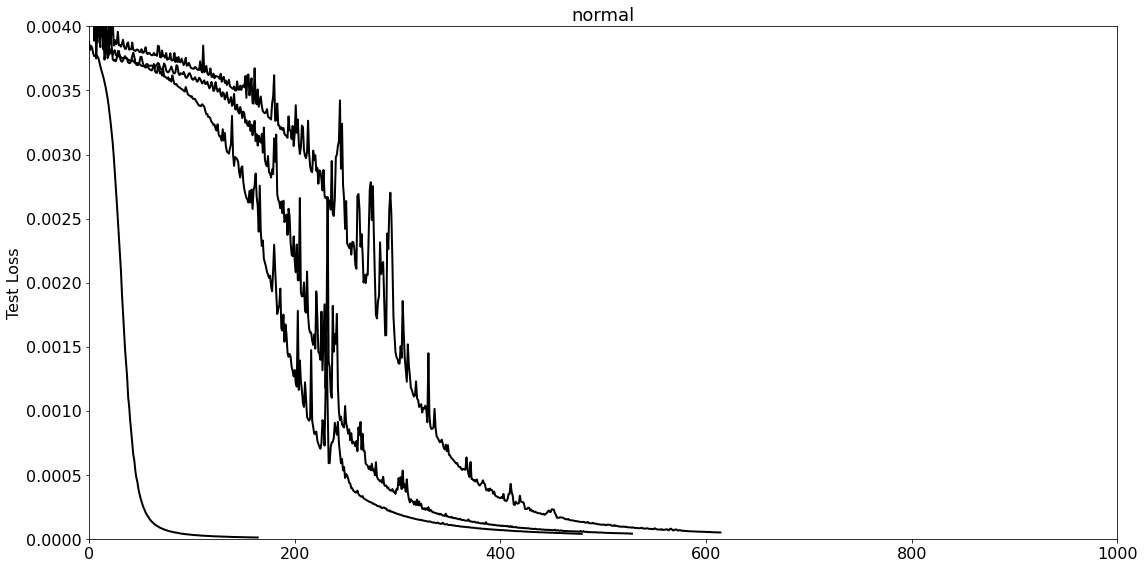

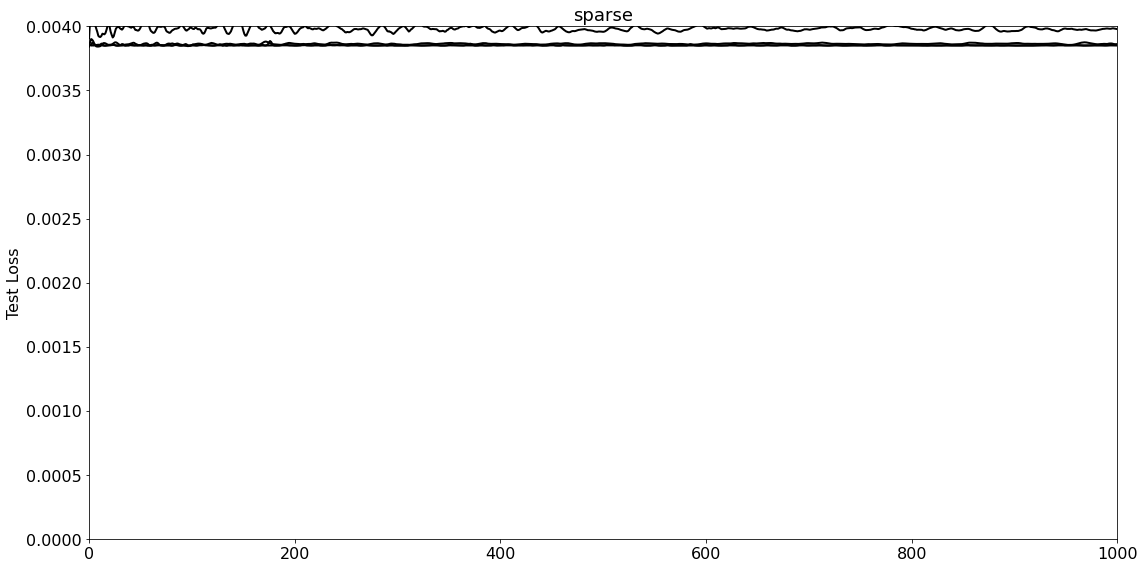

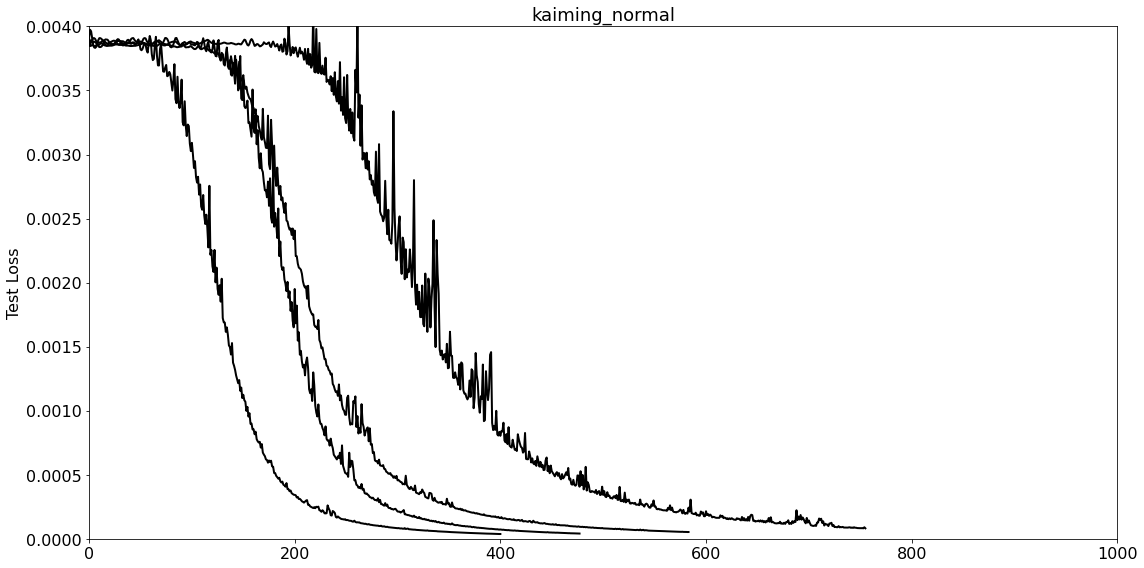

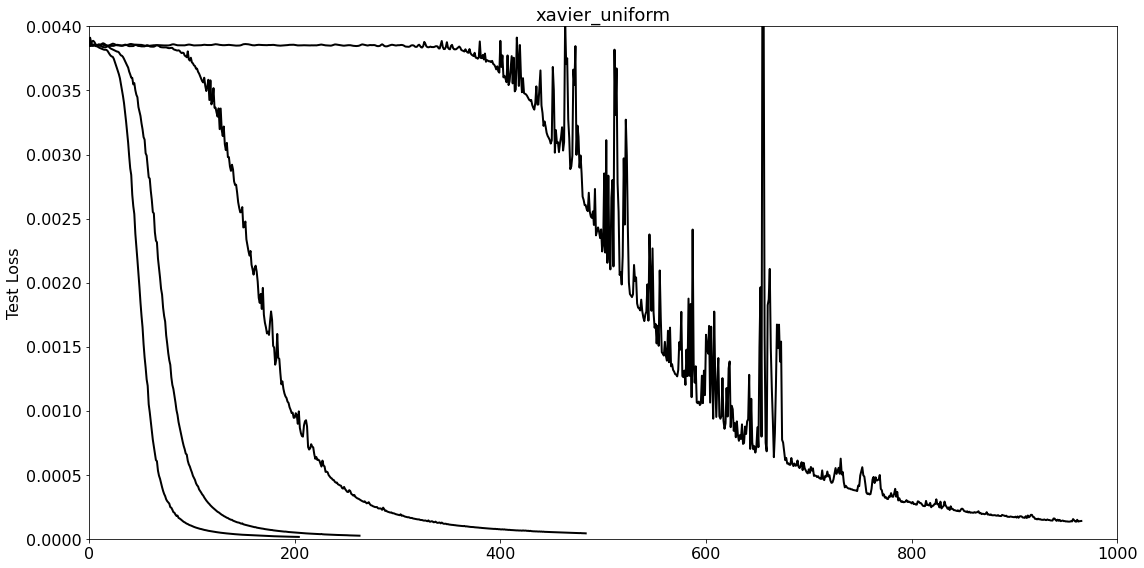

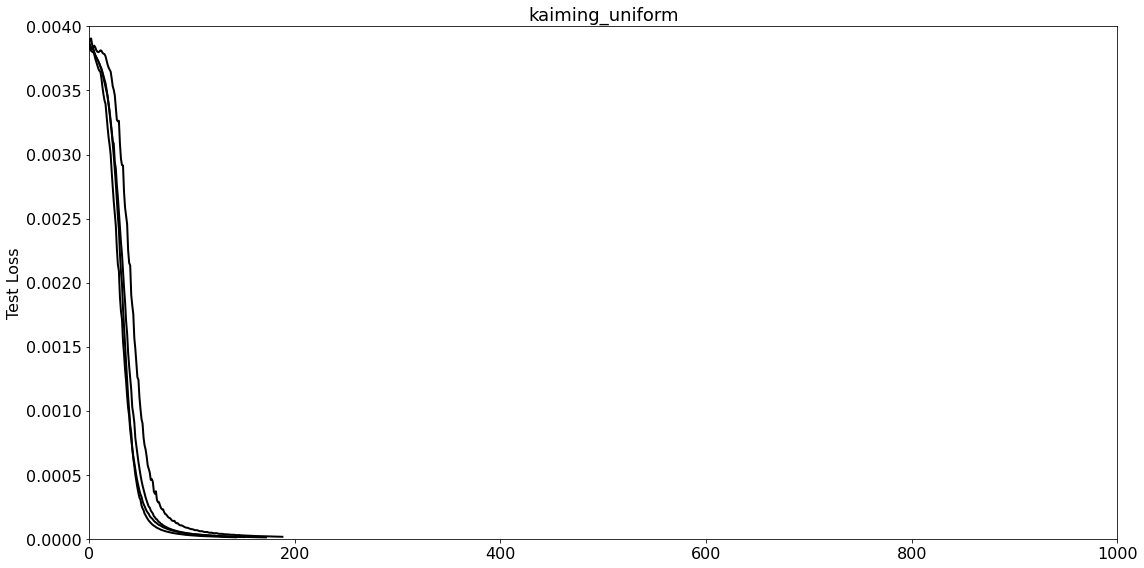

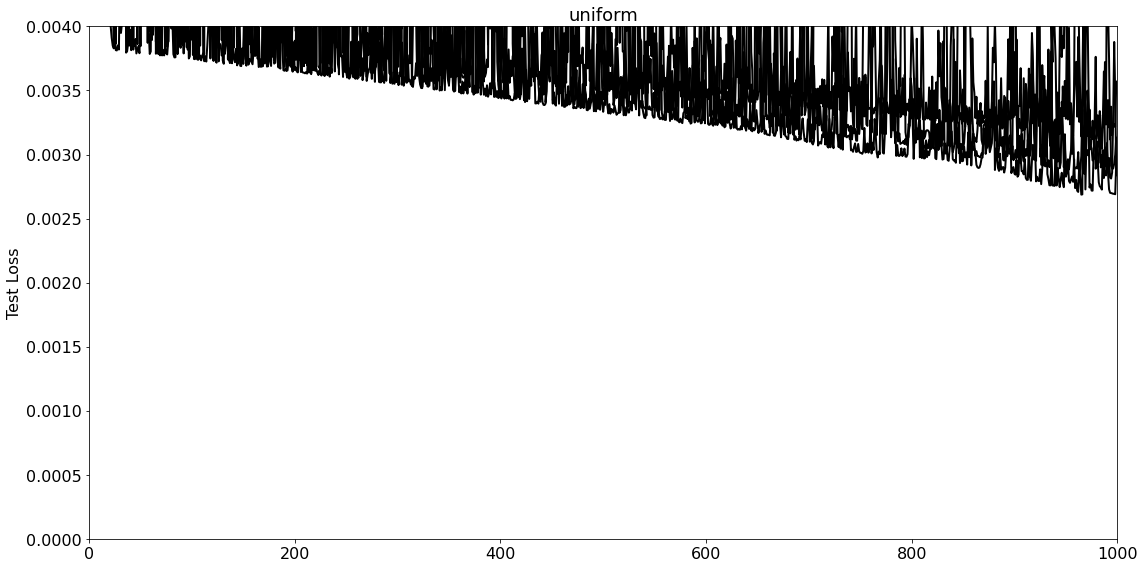

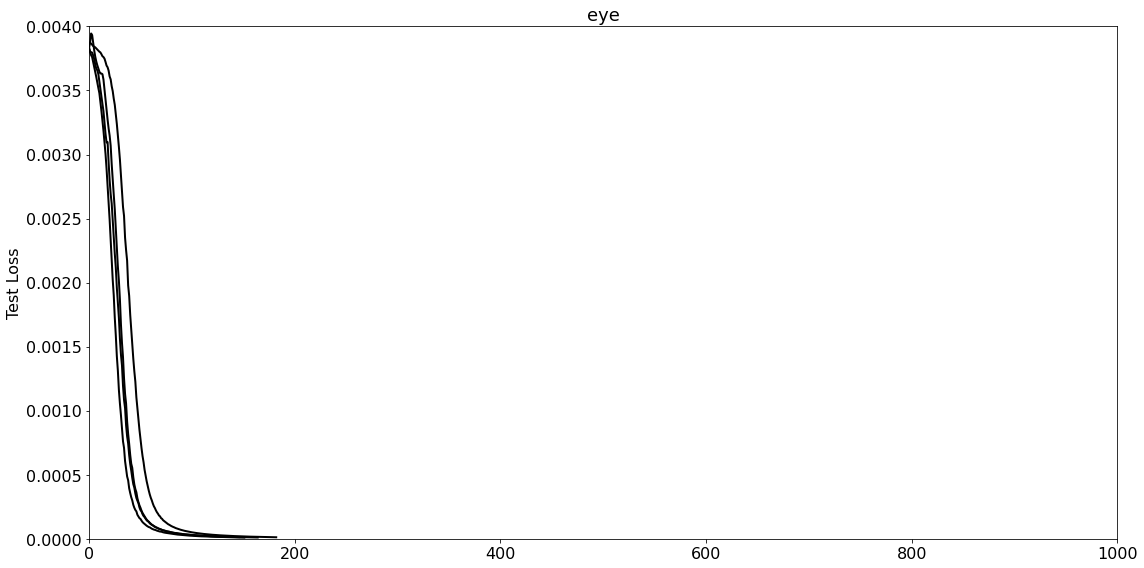

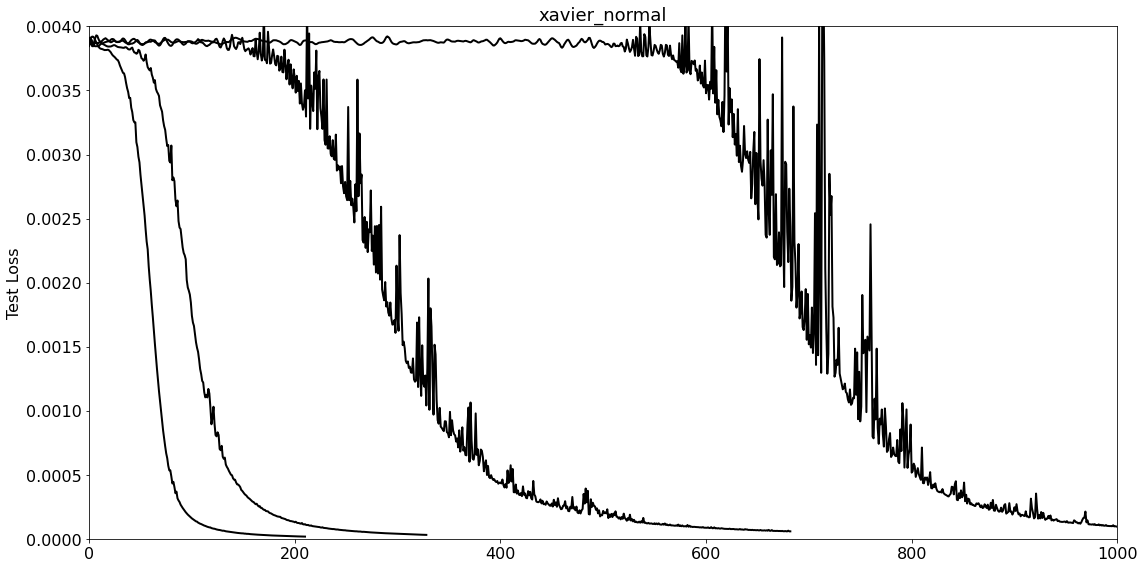

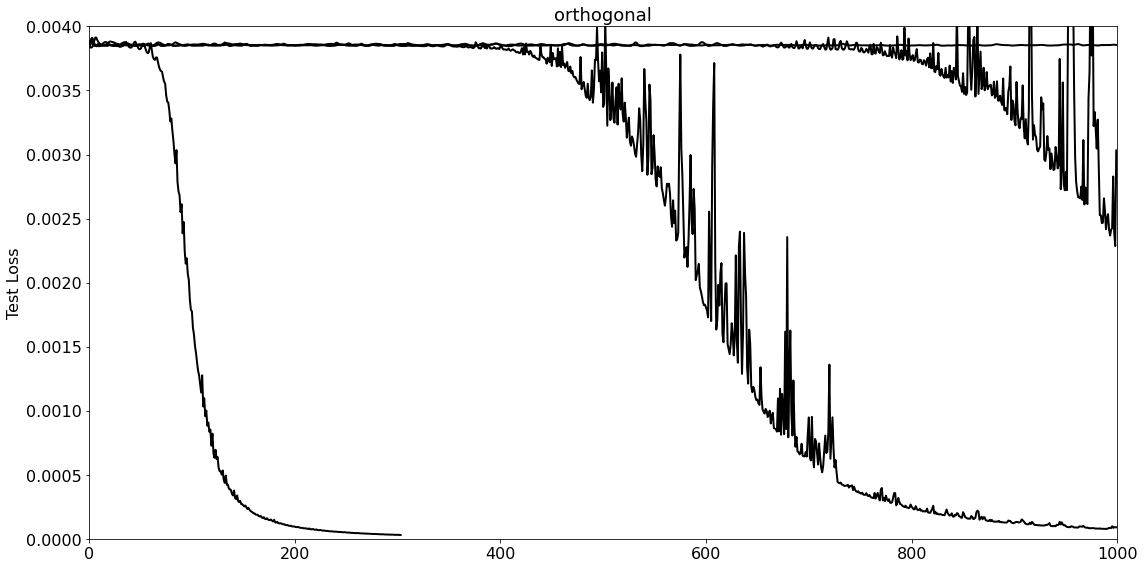

In [96]:
folder = Path("diversi_init_weights/diversi_dataset_gcn_freezed/only_testloss/")
plot_onlyloss_ripetizioni_stesso_trial(df=gc3.config_dataframe, diz_trials=diz_trials3, dot_key='model.init_weights', folder=folder, ylim=(0,0.004))

# GCN freezed - Stesso dataset

### Per ogni trial ripetuto ricalcolo un nuovo set di pesi dalla stessa distribuzione

## Codice

In [3]:
#metodi = ['normal', 'uniform', 'eye', 'xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal', 'trunc_normal', 'orthogonal', 'sparse']
diz_trials = {'model.init_weights': ['orthogonal']*50 + ['eye']*50}

In [5]:
# ricordare di cambiare il parametro freezeGCNlayers nel config
xp = Experiments(config_file, diz_trials, rootsave=rootsave)

0 configurazioni saltate su 100, farò 100 training


/home/daniele/Documenti/Progetti/Networks/Embednet/GridConfigurations.py:71: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cum = df_cum.reset_index().drop(columns=['index'])


In [6]:
xp.diversi_init_weights_stesso_dataset(parallel=True)

Carico il dataset e lo tengo invariato per tutti i trial
Generating dataset...
Dataset generated
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 47.75it/s]


Tempo impiegato: 10.312346696853638
Run 1 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:34<00:00,  4.66it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 2 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.67it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 3 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.68it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 4 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.69it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 5 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:34<00:00,  4.66it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 6 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:34<00:00,  4.67it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 7 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:35<00:00,  4.64it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 8 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:35<00:00,  4.65it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 9 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:35<00:00,  4.64it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 10 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:35<00:00,  4.64it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 11 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:35<00:00,  4.64it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 12 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:36<00:00,  4.63it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 13 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.60it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 14 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:36<00:00,  4.62it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 15 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:36<00:00,  4.62it/s]


test accuracy finale: 0.041666666666666664
calcolo i risultati di interesse
Run 16 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.59it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 17 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.58it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 18 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.59it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 19 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.57it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 20 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.58it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 21 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.57it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 22 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.56it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 23 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.55it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 24 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.56it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 25 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.59it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 26 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.58it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 27 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.58it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 28 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.57it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 29 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.56it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 30 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.56it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 31 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.57it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 32 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.56it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 33 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.52it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 34 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.53it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 35 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.54it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 36 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.52it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 37 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.52it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 38 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.52it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 39 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 40 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.53it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 41 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 42 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.51it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 43 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.49it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 44 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.48it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 45 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 46 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.47it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 47 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.49it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 48 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.49it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 49 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.47it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 50 	 metodo:orthogonal


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


test accuracy finale: 0.0
calcolo i risultati di interesse
Run 51 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 52 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 53 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.48it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 54 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.47it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 55 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.47it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 56 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 57 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.44it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 58 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 59 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.43it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 60 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 61 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.41it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 62 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.44it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 63 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.46it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 64 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.40it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 65 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 66 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 67 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.43it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 68 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 69 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 70 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 71 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.41it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 72 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 73 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.41it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 74 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.41it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 75 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.38it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 76 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.39it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 77 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.43it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 78 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 79 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.40it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 80 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 81 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.41it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 82 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.39it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 83 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.39it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 84 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:51<00:00,  4.31it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 85 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.38it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 86 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.37it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 87 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.38it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 88 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.38it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 89 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.37it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 90 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.37it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 91 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:49<00:00,  4.36it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 92 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:50<00:00,  4.34it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 93 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:49<00:00,  4.36it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 94 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:50<00:00,  4.34it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 95 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:50<00:00,  4.34it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 96 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.37it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 97 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:51<00:00,  4.33it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 98 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:52<00:00,  4.31it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 99 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:50<00:00,  4.34it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse
Run 100 	 metodo:eye


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:51<00:00,  4.32it/s]


test accuracy finale: 0.7333333333333333
calcolo i risultati di interesse


In [12]:
df.drop(df[df[('risultati', 'test_loss')] == '_'].index, inplace=True)

In [11]:
outfile = "output_data/df_configs_kaim-unif_normal_init_weights_stesso_dataset_gcn_freezed.csv"
df = xp.gc.config_dataframe
df.to_csv(outfile)

## Risultati

In [61]:
filenamesave = rootsave / folder / (f'diverse_inizializzazioni.png' )
filenamesave

PosixPath('output_plots/diversi_init_weights/stesso_dataset_gcn_freezed/only_test_loss_nonrandom/diverse_inizializzazioni.png')

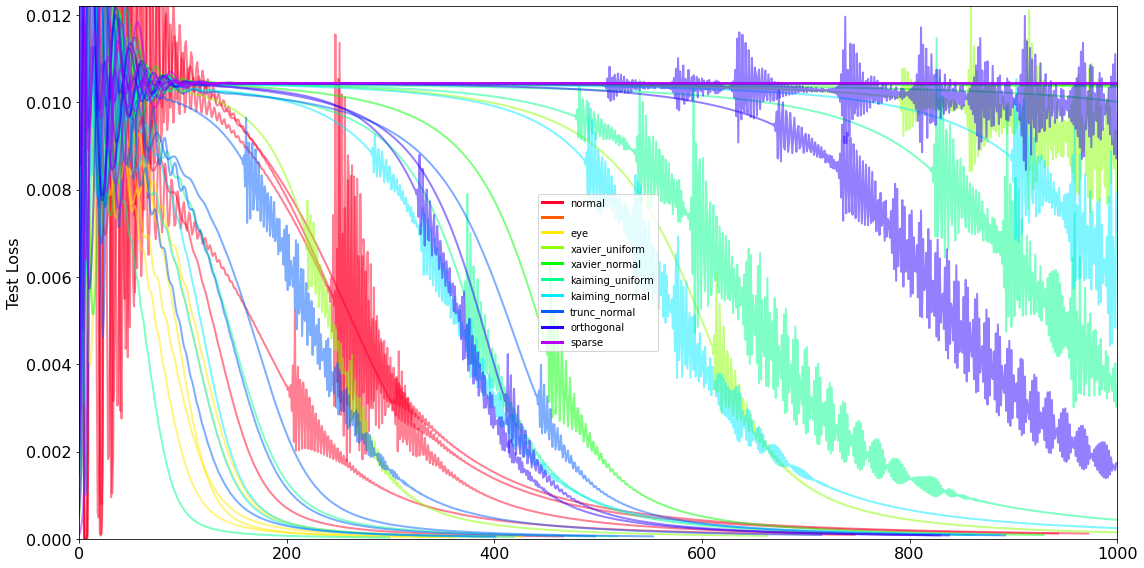

In [31]:
fname = Path("diversi_init_weights/stesso_dataset_gcn_freezed/10_methods.png")
metodi = ['normal', '', 'eye', 'xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal', 'trunc_normal', 'orthogonal', 'sparse']
plot_onlyloss_ripetizioni_stesso_trial_superimposed(xp, dot_key='model.init_weights', filename=fname, ylim=(0, 0.0122), xlim=(0,1000), lista_keys=metodi)

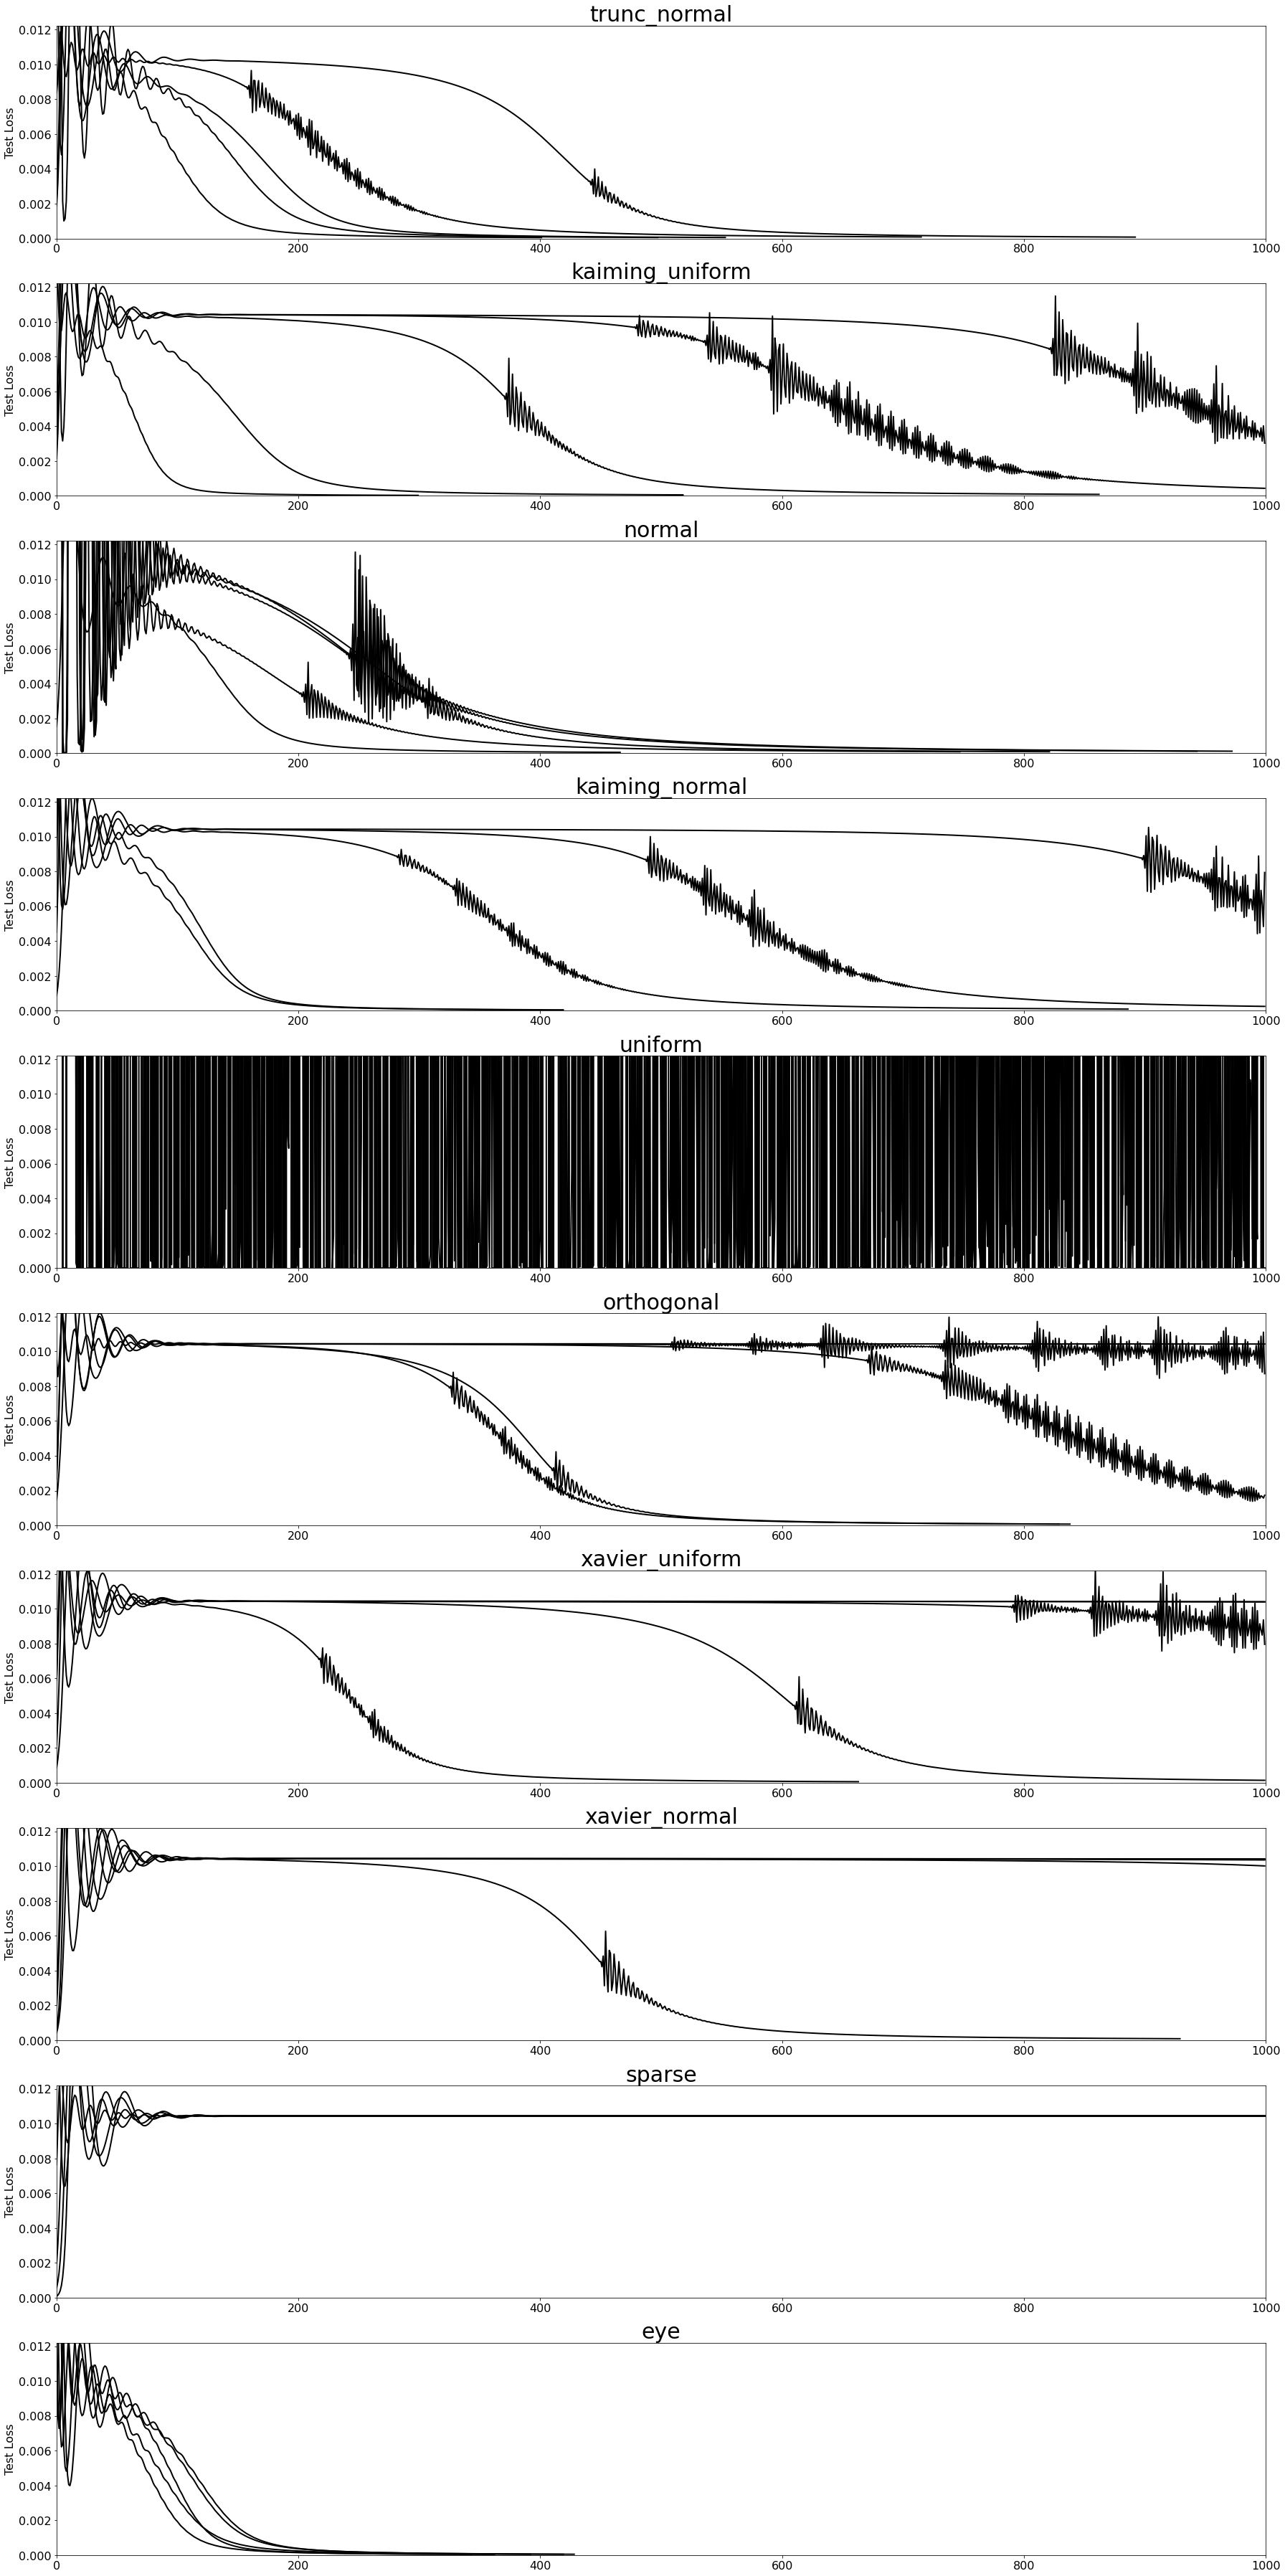

In [36]:
fname = Path("diversi_init_weights/stesso_dataset_gcn_freezed/10_methods_separati.png")
plot_onlyloss_ripetizioni_stesso_trial(xp, dot_key='model.init_weights', filename=fname, ylim=(0, 0.0122), xlim=(0,1000))

## Risultati con batchnorm e ripetuti 

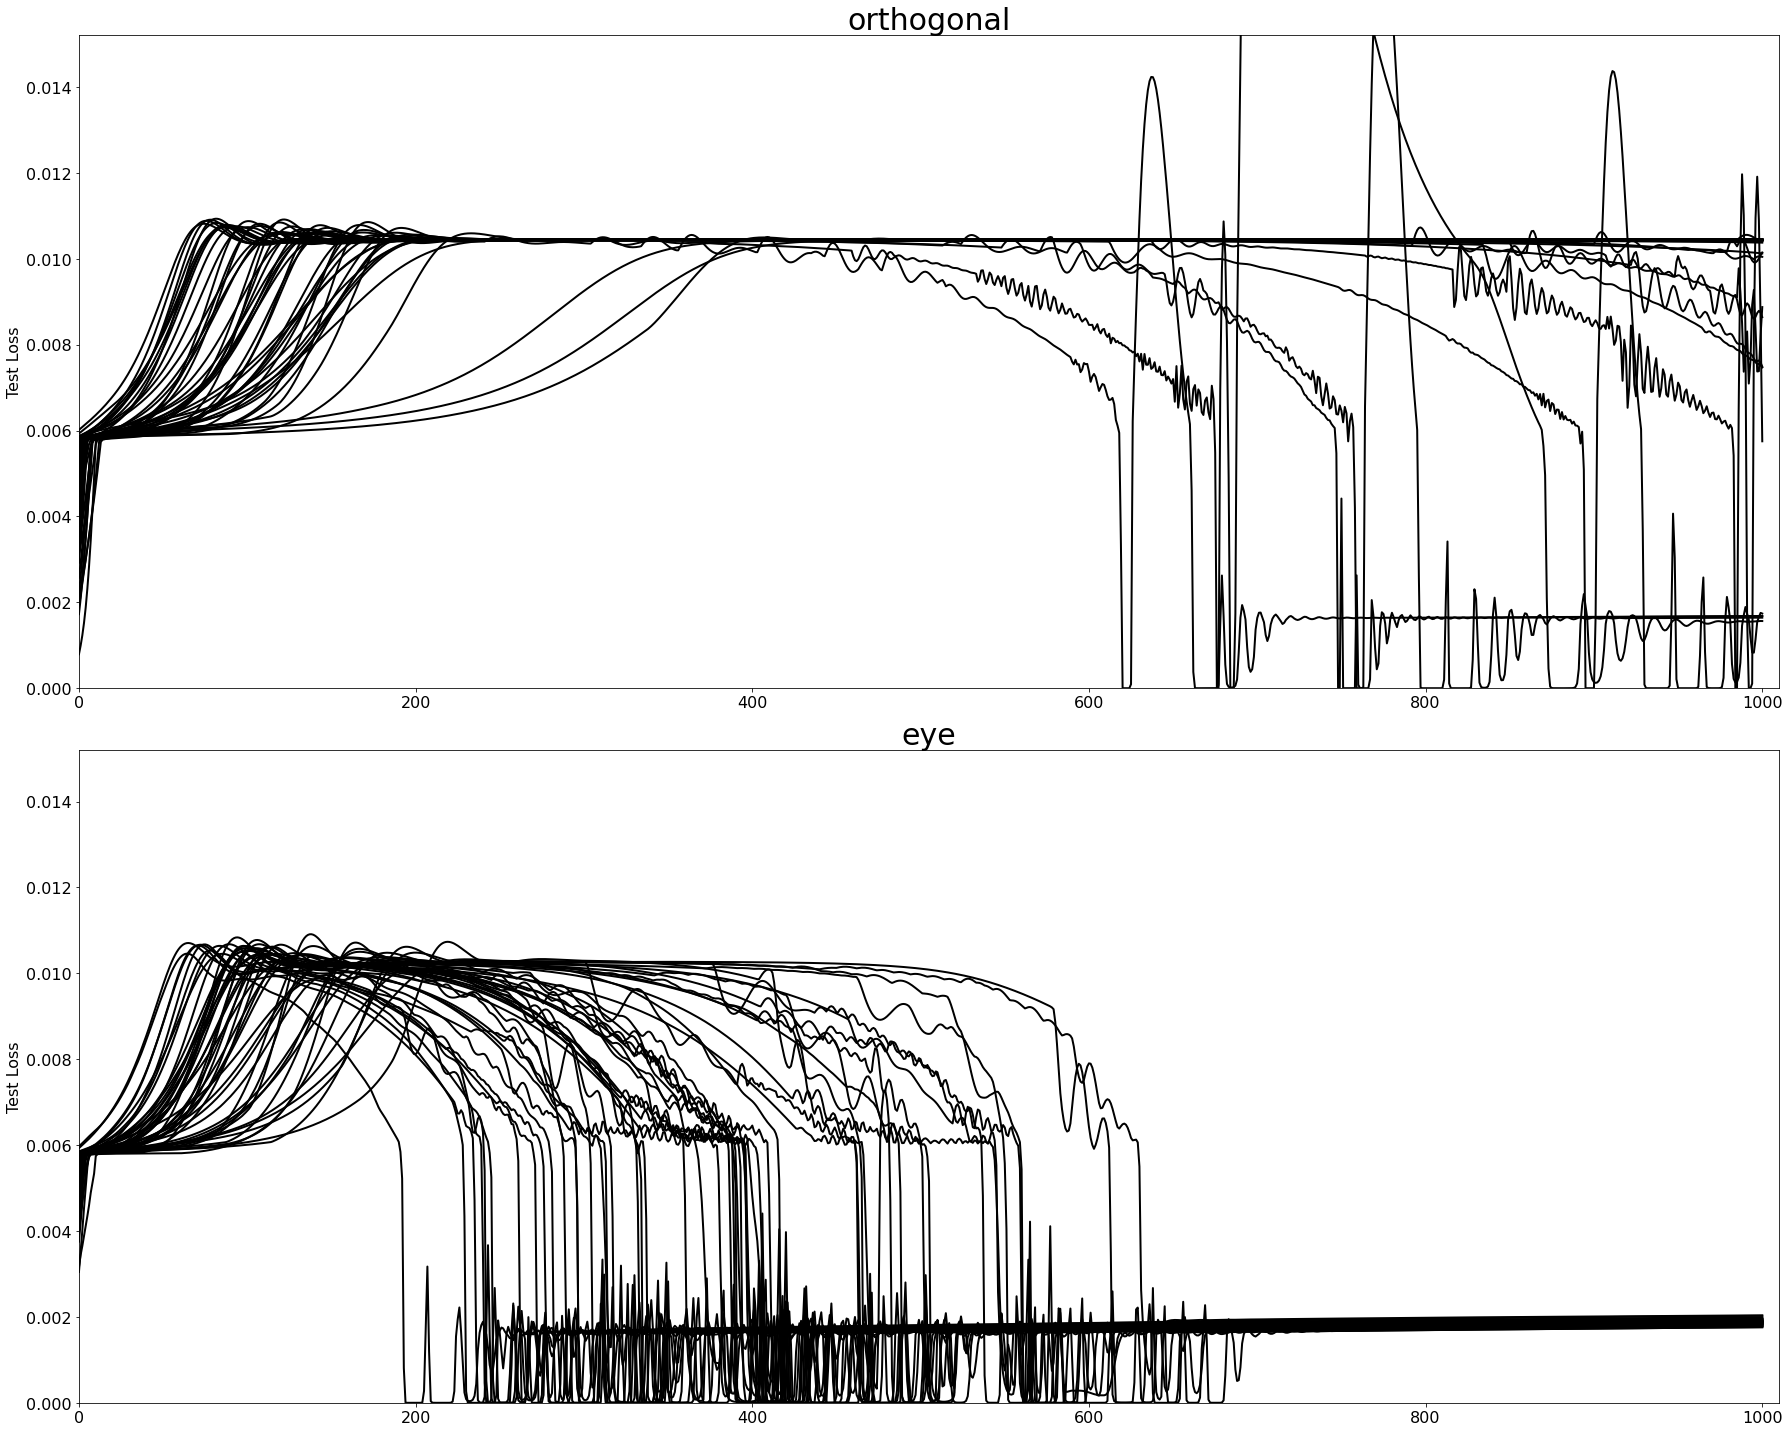

In [8]:
fname = Path("diversi_init_weights/stesso_dataset_gcn_freezed/methods_eye_orthogonal_wo-batchnorm.png")
plot_onlyloss_ripetizioni_stesso_trial(xp, dot_key='model.init_weights', filename=None, ylim=(0, 0.0152), xlim=(0,1010), figsize=(25,20))